<a href="https://colab.research.google.com/github/10810310/GitHubDemo/blob/main/DQN_trader_stage3_0_%E9%A0%90%E6%B8%ACshare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 盤中程式自動交易DQN_測試

交易標的為台指期,模型為DQN, 訓練及測試資料為證交所每五秒交易紀錄資料.目標為DQN模型在盤中依照即時指數變化自動交易(hold,buy,sell),交易後(buy/sell)以Line通知交易價格及數量,並每日彙整交易報表,程式分訓練及測試2部

In [ ]:
#!pip install pandas-datareader

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
import xgboost as xgb
from tqdm import tqdm_notebook, tqdm
from collections import deque
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from functools import lru_cache

from datetime import timedelta, date, datetime
import time
import requests
from io import StringIO
from keras.models import load_model
import math
import os

# 測試1:使用訓練時保留的資料測試交易績效

In [ ]:
#將訓練時爬下的證交所交易資料讀入
df_crawlered1 = pd.read_csv('/content/gdrive/My Drive/twse_index.csv',index_col=0, dtype={'時間': 'str', '發行量加權股價指數': 'str'}, parse_dates=['時間'])

In [ ]:
# 去除','並將str轉成float
df_crawlered1['發行量加權股價指數']= list(map(float, [item.replace(',','') for item in df_crawlered1['發行量加權股價指數'] ]))


In [ ]:
#檢查是否有空值
print(df_crawlered1.isnull().sum())


時間           0
發行量加權股價指數    0
dtype: int64


In [ ]:
#參考例:如果需要調整資料口徑可參考
#df_crawlered_10sec =df_crawlered[df_crawlered.index%2 ==0].copy().reset_index(drop=True)

In [ ]:
# 重要參數
window_size = 360 # 依照window_size筆資料(360*5sec約30mins）做預測
batch_size =  64 # 每次DNN模型訓練使用最新64筆memory()
best_episode = 9 # 選擇訓練時最佳的episode
max_inventory = 30 # 設定程式自動買賣最大允許庫存數

In [ ]:
print(df_crawlered1.shape)

(350028, 2)


In [ ]:
#設定sigmoid函數並使用cache加速
@lru_cache(maxsize=1024)  #增加cache memory
def sigmoid(x): #轉換值介於0-1
  return 1 / (1 + math.exp(-x))


# 設定函數將結果取到小數第二位
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
df_crawlered = df_crawlered1 
sigmoid_df= df_crawlered['發行量加權股價指數']-df_crawlered['發行量加權股價指數'].shift(1) #取漲跌值
sigmoid_df[0,0]=0
sigmoid_df = sigmoid_df.map(sigmoid)#將漲跌值壓縮在0-1之間

In [ ]:
df_crawlered

,時間,發行量加權股價指數
0,2020-05-20 09:00:00,10860.44
1,2020-05-20 09:00:05,10892.76
2,2020-05-20 09:00:10,10898.10
3,2020-05-20 09:00:15,10906.65
4,2020-05-20 09:00:20,10910.53
...,...,...
350023,2020-10-23 13:29:40,12903.43
350024,2020-10-23 13:29:45,12903.43
350025,2020-10-23 13:29:50,12903.43
350026,2020-10-23 13:29:55,12903.43


In [ ]:
# test的資料切割點
train_ratio = 0.8 #crawlered1_df是訓練時下載的資料集,訓練用了前面80%資料,使用後20%未訓練過的資料
sep_idx = int(df_crawlered.shape[0]*train_ratio) #取切割的index

# 分割出test
df_test = sigmoid_df[sep_idx:].copy().reset_index(drop=True) #取sep_index之後的
actual_price_df = df_crawlered[sep_idx:].copy()['發行量加權股價指數'].values
print(df_test.shape, len(actual_price_df))


(70006,) 70006


In [ ]:
actual_price_df[:5]

array([12848.1 , 12848.67, 12844.04, 12844.57, 12843.29])

In [ ]:
class DQN_trader():
  
  def __init__(self, state_size, best_episode, action_num=3, model_name="DQN_trader"): # state_size=>window_size(360)個壓縮為simoid值的漲跌幅變化來判斷hold,buy,sell)
    self.state_size = state_size
    self.action_num = action_num # number = 3 (有三種action: hold, buy, sell)
    self.memory = deque(maxlen=2000) # que記憶最大2000組
    self.inventory = [] # 設買入庫存紀錄list
    self.model_name = model_name
    self.best_episode = best_episode
    
    self.gamma = 0.618 #用來調整下次reward預測值的重要性
    self.epsilon = 0 # 預測調為0, 訓練時1, 隨機或預測的threshold
    self.epsilon_final = 0.01 # 最低epsilon值
    self.epsilon_decay = 0.995 # 每次epsilon遞減比率: 千分之五
    
    self.model = self.model_dnn()
    
  def model_dnn(self):
    #載入訓練最好的model
    model= load_model(("/content/gdrive/My Drive/DQN股價預測/ai_trader_{}.h5".format(self.best_episode))) 
    
  #  model = tf.keras.models.Sequential()
    
  #  model.add(tf.keras.layers.Dense(units=16, activation='relu', input_dim=self.state_size))
    
  #  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    
  #  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    
  #  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    
  #  model.add(tf.keras.layers.Dense(units=self.action_num, activation='linear'))
    # 最後輸出3個linear值,然後做argmax
  #  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3))
    
    return model
  
  def trade(self, state):
    # random or use dnn model to predict action
    
    if random.random() <= self.epsilon: # 進入預測後, epsilon已經設為0,所以不會進入隨機判斷
      return random.randrange(self.action_num)
    
    actions = self.model.predict(state) #predict出三組數字然後argmax產出0,1,2三個數字 #0hold, 1Buy, 2Sell
    return np.argmax(actions[0]) 
  
  @lru_cache(maxsize=1024)
  def batch_train(self, batch_size): 
    
    batch = []
    #取最新64筆memory
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i]) # 取出最新batch_size(64)筆memory, 每個memory包含5個items
      
    for state, action, reward, next_state, done in batch: #逐次取出5個items
      reward = reward
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])#引導模型往這次＋預期下次reward方向擬合
        
      target = self.model.predict(state)
      target[0][action] = reward
      
      self.model.fit(state, target, epochs=1, verbose=0) #以過去64筆memory訓練模型來做預測
      
    if self.epsilon > self.epsilon_final: # final值為0.01
      self.epsilon *= self.epsilon_decay # epsilon初始值1, 每次遞減千分之五

In [ ]:
trader = DQN_trader(window_size, best_episode) # window_size用來設定DNN的輸入dimension

In [ ]:
trader.model.summary() # 輸出3個linear數字（訓練時3個數字的y值為環境reward)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               46208     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 77,315
Trainable params: 77,315
Non-traina

In [ ]:
class line_notify():
    
    def __init__(self, api_token, line_token):
        
        self.api_token = api_token
        self.line_token = line_token
        
    def lineNotifyMessage(self, msg):
    
        headers = {
           "Authorization": "Bearer " + self.line_token, 
           "Content-Type" : "application/x-www-form-urlencoded"
       }

        payload = {'message': msg}
        r = requests.post("https://notify-api.line.me/api/notify", headers = headers, params = payload)
        return r.status_code
    
    def buy_sell_notify(self, symbol_id, action , target_price , profit):


        if action == 1:
            self.lineNotifyMessage('重要通知！' + symbol_id + '程式已自動交易[買]了' + str(target_price) + '元\n')

        elif action == 2:
            self.lineNotifyMessage('重要通知！' + symbol_id + '程式已自動交易[賣]了' + str(target_price) + '，獲利：' + str(profit) + '元\n')

        else:
            pass
    
 

In [ ]:
# line_token申請url: https://notify-bot.line.me/zh_TW/
line_token = '這裡請輸入到上面url申請的token'

line = line_notify(line_token= line_token,
                   api_token='自動程式交易通知')

In [ ]:
#測試Line通知功能(需先申請token)
line.buy_sell_notify(symbol_id='台指期TXF10',action=1,target_price=123,profit=123)   

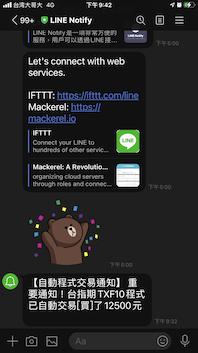

In [ ]:
# the history of buy, sell, profit, inventory, total profit
trading_history=pd.DataFrame(columns = ['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總'])

In [ ]:
learned_memory = pickle.load(open('/content/gdrive/My Drive/DQN股價預測/learned_memory.pkl', 'rb'))

print([x[1] for x in learned_memory]) #概覽learned_memory的0,1,2action分布

[2, 0, 0, 1, 1, 2, 0, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 0, 2, 1, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 

In [ ]:
len(learned_memory[0][0][0]) #確認learned_memory的window_size相符

360

In [ ]:
# predict 
# 以line即時通知交易: 程式自動買入賣出與獲利

# 測試資料
data = df_test.values

# 載入之前memory
learned_memory = pickle.load(open('/content/gdrive/My Drive/DQN股價預測/learned_memory.pkl', 'rb'))  
trader.memory = learned_memory
# 載入memory中最後一個state
state = deque(learned_memory[-1][3][0], maxlen= window_size)
# 產生第一個state
state.append(data[0])

  
#設定初始值
total_profit = 0
buy_count, sell_count = 0, 0
trader.inventory = []
reward = 0


print("====程式開始自動交易====")
for timestep in tqdm(range(1,2000)): #len(data))): # 走test所有資料
  #print(f'timestep is {timestep}')
  curr_state = np.array(state).reshape(-1, window_size) 
  #print(f'curr_state is {curr_state}')
  action = trader.trade(curr_state) # 產出第一個action(非隨機, 是模型預測)
  #print(f'action is {action}')
  state.append(data[timestep])
  next_state = np.array(state).reshape(-1, window_size)
  #print(f'next_state is {next_state}')
  
  
  if action == 1 and len(trader.inventory) < max_inventory: #Buying
    trader.inventory.append(actual_price_df[timestep]) # 在此記入買時價格
    print("DQN Trader bought: ", stocks_price_format(actual_price_df[timestep]))
    buy_count+=1
    #line通知買入及買入價格
    line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[timestep]),profit=0)
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history.loc[len(trading_history)]=['TXF10', '台指期10', action, stocks_price_format(actual_price_df[timestep]), 'NaN', len(trader.inventory), total_profit ] 
    
  elif action == 2 and len(trader.inventory) > 0: #Selling
    buy_price = trader.inventory.pop(0)
    sell_count+=1
    reward = max(actual_price_df[timestep] - buy_price, 0) # reward指環境回饋, 最小值為0 
    total_profit += actual_price_df[timestep] - buy_price # 這裡才反應實際賺賠金額
    print("DQN Trader sold: ", stocks_price_format(actual_price_df[timestep]), " Profit: " + stocks_price_format(actual_price_df[timestep] - buy_price) )
    # line通知
    line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[timestep]),profit=stocks_price_format(data[timestep] - buy_price))
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history.loc[len(trading_history)]=['TXF10', '台指期10', action, stocks_price_format(actual_price_df[timestep]), stocks_price_format(actual_price_df[timestep] - buy_price), len(trader.inventory) , total_profit] 

  if timestep == len(data)-1: # 跑到最後一筆資料了
    done = True
  else:
    done = False
    
  trader.memory.append((curr_state, action, reward, next_state, done))
  
  
  if done:
    #print("########################")
    print(f"Today's Profit: {total_profit}, Buy: {buy_count}, Sell: {sell_count}, UNSOLD_inventory: {len(trader.inventory)}")
    #print("########################")

  
  if len(trader.memory) > batch_size: # 用最新32個memory訓練DNN
    trader.batch_train(batch_size)

# 存檔交易歷史
trading_history.to_csv('/content/gdrive/My Drive/DQN股價預測/trading_history.csv',encoding='utf-8', index=False )  

# 存檔memory
learned_memory = trader.memory
f = open("/content/gdrive/My Drive/DQN股價預測/test_learned_memory.pkl",'wb')
pickle.dump(learned_memory, f)


====程式開始自動交易====


  0%|          | 2/1999 [00:00<01:43, 19.37it/s]

DQN Trader bought:  $ 12848.990000
DQN Trader bought:  $ 12839.660000


  0%|          | 4/1999 [00:01<14:04,  2.36it/s]

DQN Trader sold:  $ 12836.110000  Profit: - $ 12.880000


  0%|          | 5/1999 [00:02<15:53,  2.09it/s]

DQN Trader bought:  $ 12835.720000


  0%|          | 6/1999 [00:02<17:28,  1.90it/s]

DQN Trader sold:  $ 12835.150000  Profit: - $ 4.510000


  0%|          | 7/1999 [00:03<18:11,  1.83it/s]

DQN Trader bought:  $ 12833.150000


  0%|          | 9/1999 [00:03<14:45,  2.25it/s]

DQN Trader bought:  $ 12831.100000


  1%|          | 10/1999 [00:04<16:08,  2.05it/s]

DQN Trader bought:  $ 12828.330000


  1%|          | 12/1999 [00:05<14:48,  2.24it/s]

DQN Trader bought:  $ 12828.060000


  1%|          | 14/1999 [00:06<13:21,  2.48it/s]

DQN Trader bought:  $ 12828.420000


  1%|          | 16/1999 [00:06<12:31,  2.64it/s]

DQN Trader sold:  $ 12827.160000  Profit: - $ 8.560000


  1%|          | 17/1999 [00:07<14:02,  2.35it/s]

DQN Trader sold:  $ 12829.780000  Profit: - $ 3.370000


  1%|          | 19/1999 [00:07<13:00,  2.54it/s]

DQN Trader bought:  $ 12824.330000


  1%|          | 21/1999 [00:08<12:21,  2.67it/s]

DQN Trader sold:  $ 12826.710000  Profit: - $ 4.390000


  1%|▏         | 25/1999 [00:09<08:14,  3.99it/s]

DQN Trader sold:  $ 12832.290000  Profit: $ 3.960000


  1%|▏         | 26/1999 [00:10<10:24,  3.16it/s]

DQN Trader sold:  $ 12827.240000  Profit: - $ 0.820000


  1%|▏         | 27/1999 [00:10<13:46,  2.39it/s]

DQN Trader sold:  $ 12828.990000  Profit: $ 0.570000


  1%|▏         | 29/1999 [00:11<12:37,  2.60it/s]

DQN Trader bought:  $ 12836.950000


  2%|▏         | 32/1999 [00:12<10:23,  3.16it/s]

DQN Trader sold:  $ 12839.090000  Profit: $ 14.760000


  2%|▏         | 33/1999 [00:12<12:02,  2.72it/s]

DQN Trader bought:  $ 12839.590000


  2%|▏         | 34/1999 [00:13<13:40,  2.39it/s]

DQN Trader sold:  $ 12834.900000  Profit: - $ 2.050000


  2%|▏         | 35/1999 [00:14<15:09,  2.16it/s]

DQN Trader bought:  $ 12835.880000


  2%|▏         | 36/1999 [00:14<16:21,  2.00it/s]

DQN Trader bought:  $ 12840.130000


  2%|▏         | 38/1999 [00:15<14:59,  2.18it/s]

DQN Trader sold:  $ 12840.900000  Profit: $ 1.310000


  2%|▏         | 39/1999 [00:16<16:02,  2.04it/s]

DQN Trader sold:  $ 12842.350000  Profit: $ 6.470000


  2%|▏         | 40/1999 [00:16<17:01,  1.92it/s]

DQN Trader bought:  $ 12842.880000


  2%|▏         | 41/1999 [00:17<17:46,  1.84it/s]

DQN Trader sold:  $ 12843.020000  Profit: $ 2.890000


  2%|▏         | 43/1999 [00:17<14:40,  2.22it/s]

DQN Trader sold:  $ 12845.070000  Profit: $ 2.190000


  2%|▏         | 44/1999 [00:18<15:55,  2.05it/s]

DQN Trader bought:  $ 12843.900000


  2%|▏         | 45/1999 [00:19<17:01,  1.91it/s]

DQN Trader bought:  $ 12843.630000


  2%|▏         | 46/1999 [00:19<17:48,  1.83it/s]

DQN Trader sold:  $ 12843.080000  Profit: - $ 0.820000


  2%|▏         | 47/1999 [00:20<19:37,  1.66it/s]

DQN Trader bought:  $ 12850.170000


  3%|▎         | 50/1999 [00:21<13:07,  2.47it/s]

DQN Trader bought:  $ 12852.090000


  3%|▎         | 52/1999 [00:21<12:21,  2.63it/s]

DQN Trader sold:  $ 12847.670000  Profit: $ 4.040000


  3%|▎         | 53/1999 [00:22<13:48,  2.35it/s]

DQN Trader sold:  $ 12847.800000  Profit: - $ 2.370000


  3%|▎         | 54/1999 [00:23<15:07,  2.14it/s]

DQN Trader sold:  $ 12851.800000  Profit: - $ 0.290000


  3%|▎         | 56/1999 [00:23<13:20,  2.43it/s]

DQN Trader bought:  $ 12851.730000


  3%|▎         | 58/1999 [00:24<12:29,  2.59it/s]

DQN Trader bought:  $ 12852.900000


  3%|▎         | 60/1999 [00:25<12:10,  2.65it/s]

DQN Trader bought:  $ 12852.770000


  3%|▎         | 61/1999 [00:25<13:37,  2.37it/s]

DQN Trader bought:  $ 12852.720000


  3%|▎         | 62/1999 [00:26<15:02,  2.15it/s]

DQN Trader sold:  $ 12853.690000  Profit: $ 1.960000


  3%|▎         | 63/1999 [00:27<16:10,  1.99it/s]

DQN Trader sold:  $ 12854.220000  Profit: $ 1.320000


  3%|▎         | 64/1999 [00:27<17:09,  1.88it/s]

DQN Trader bought:  $ 12854.960000


  3%|▎         | 65/1999 [00:28<17:54,  1.80it/s]

DQN Trader sold:  $ 12855.440000  Profit: $ 2.670000


  3%|▎         | 67/1999 [00:28<14:49,  2.17it/s]

DQN Trader bought:  $ 12854.360000


  3%|▎         | 68/1999 [00:29<16:00,  2.01it/s]

DQN Trader sold:  $ 12854.400000  Profit: $ 1.680000


  3%|▎         | 69/1999 [00:30<16:58,  1.90it/s]

DQN Trader bought:  $ 12855.650000


  4%|▎         | 70/1999 [00:30<19:13,  1.67it/s]

DQN Trader sold:  $ 12855.720000  Profit: $ 0.760000


  4%|▎         | 71/1999 [00:31<19:20,  1.66it/s]

DQN Trader sold:  $ 12855.430000  Profit: $ 1.070000


  4%|▎         | 72/1999 [00:32<19:20,  1.66it/s]

DQN Trader bought:  $ 12856.420000


  4%|▎         | 74/1999 [00:32<15:24,  2.08it/s]

DQN Trader sold:  $ 12861.880000  Profit: $ 6.230000


  4%|▍         | 76/1999 [00:33<13:31,  2.37it/s]

DQN Trader sold:  $ 12856.730000  Profit: $ 0.310000


  4%|▍         | 80/1999 [00:34<08:23,  3.81it/s]

DQN Trader bought:  $ 12860.900000


  4%|▍         | 82/1999 [00:34<09:01,  3.54it/s]

DQN Trader sold:  $ 12854.770000  Profit: - $ 6.130000


  4%|▍         | 83/1999 [00:35<11:40,  2.74it/s]

DQN Trader bought:  $ 12854.660000


  4%|▍         | 84/1999 [00:36<13:22,  2.39it/s]

DQN Trader sold:  $ 12859.750000  Profit: $ 5.090000


  5%|▍         | 91/1999 [00:37<05:24,  5.89it/s]

DQN Trader bought:  $ 12852.420000
DQN Trader sold:  $ 12851.840000  Profit: - $ 0.580000


  5%|▍         | 96/1999 [00:38<06:26,  4.93it/s]

DQN Trader bought:  $ 12849.430000


  5%|▍         | 98/1999 [00:39<07:27,  4.25it/s]

DQN Trader bought:  $ 12848.280000


  5%|▍         | 99/1999 [00:39<09:20,  3.39it/s]

DQN Trader sold:  $ 12846.370000  Profit: - $ 3.060000


  5%|▌         | 100/1999 [00:40<12:32,  2.52it/s]

DQN Trader sold:  $ 12847.880000  Profit: - $ 0.400000


  5%|▌         | 104/1999 [00:41<08:05,  3.90it/s]

DQN Trader bought:  $ 12845.940000


  5%|▌         | 106/1999 [00:42<08:53,  3.55it/s]

DQN Trader sold:  $ 12845.970000  Profit: $ 0.030000


  6%|▌         | 116/1999 [00:43<03:59,  7.87it/s]

DQN Trader bought:  $ 12844.920000


  6%|▌         | 118/1999 [00:44<05:39,  5.54it/s]

DQN Trader sold:  $ 12844.460000  Profit: - $ 0.460000


  6%|▌         | 120/1999 [00:44<06:57,  4.50it/s]

DQN Trader bought:  $ 12848.960000


  6%|▌         | 123/1999 [00:45<07:43,  4.05it/s]

DQN Trader sold:  $ 12844.760000  Profit: - $ 4.200000


  6%|▋         | 127/1999 [00:46<06:20,  4.92it/s]

DQN Trader bought:  $ 12844.310000


  7%|▋         | 130/1999 [00:47<06:42,  4.64it/s]

DQN Trader sold:  $ 12843.290000  Profit: - $ 1.020000


  7%|▋         | 132/1999 [00:47<07:34,  4.11it/s]

DQN Trader bought:  $ 12844.800000


  7%|▋         | 135/1999 [00:48<07:28,  4.16it/s]

DQN Trader sold:  $ 12843.310000  Profit: - $ 1.490000


  7%|▋         | 136/1999 [00:49<09:07,  3.40it/s]

DQN Trader bought:  $ 12844.330000


  7%|▋         | 139/1999 [00:49<08:26,  3.67it/s]

DQN Trader sold:  $ 12844.770000  Profit: $ 0.440000


  7%|▋         | 140/1999 [00:50<10:53,  2.84it/s]

DQN Trader bought:  $ 12845.160000


  7%|▋         | 142/1999 [00:51<10:40,  2.90it/s]

DQN Trader sold:  $ 12844.830000  Profit: - $ 0.330000


  7%|▋         | 146/1999 [00:52<07:26,  4.15it/s]

DQN Trader bought:  $ 12846.680000


  8%|▊         | 150/1999 [00:52<06:13,  4.95it/s]

DQN Trader bought:  $ 12846.920000


  8%|▊         | 152/1999 [00:53<07:24,  4.16it/s]

DQN Trader sold:  $ 12846.220000  Profit: - $ 0.460000


  8%|▊         | 153/1999 [00:54<09:25,  3.26it/s]

DQN Trader bought:  $ 12846.350000


  8%|▊         | 154/1999 [00:54<11:23,  2.70it/s]

DQN Trader bought:  $ 12845.060000


  8%|▊         | 156/1999 [00:55<11:02,  2.78it/s]

DQN Trader bought:  $ 12846.040000


  8%|▊         | 157/1999 [00:55<12:39,  2.42it/s]

DQN Trader bought:  $ 12845.240000


  8%|▊         | 159/1999 [00:56<11:38,  2.64it/s]

DQN Trader bought:  $ 12845.460000


  8%|▊         | 160/1999 [00:57<13:06,  2.34it/s]

DQN Trader bought:  $ 12845.460000


  8%|▊         | 161/1999 [00:57<14:24,  2.13it/s]

DQN Trader sold:  $ 12841.040000  Profit: - $ 5.880000


  8%|▊         | 163/1999 [00:58<12:42,  2.41it/s]

DQN Trader sold:  $ 12844.780000  Profit: - $ 1.570000


  8%|▊         | 165/1999 [00:59<11:39,  2.62it/s]

DQN Trader bought:  $ 12840.670000


  8%|▊         | 166/1999 [00:59<13:06,  2.33it/s]

DQN Trader sold:  $ 12845.810000  Profit: $ 0.750000


  8%|▊         | 168/1999 [01:00<12:15,  2.49it/s]

DQN Trader bought:  $ 12845.520000


  8%|▊         | 169/1999 [01:01<13:37,  2.24it/s]

DQN Trader sold:  $ 12845.510000  Profit: - $ 0.530000


  9%|▊         | 170/1999 [01:01<14:47,  2.06it/s]

DQN Trader sold:  $ 12844.320000  Profit: - $ 0.920000


  9%|▊         | 171/1999 [01:02<15:46,  1.93it/s]

DQN Trader bought:  $ 12844.770000


  9%|▊         | 172/1999 [01:02<16:28,  1.85it/s]

DQN Trader sold:  $ 12845.030000  Profit: - $ 0.430000


  9%|▊         | 173/1999 [01:03<17:03,  1.78it/s]

DQN Trader sold:  $ 12844.450000  Profit: - $ 1.010000


  9%|▊         | 174/1999 [01:04<17:25,  1.75it/s]

DQN Trader sold:  $ 12843.230000  Profit: $ 2.560000


  9%|▉         | 175/1999 [01:04<17:44,  1.71it/s]

DQN Trader sold:  $ 12839.490000  Profit: - $ 6.030000


  9%|▉         | 176/1999 [01:05<19:42,  1.54it/s]

DQN Trader sold:  $ 12839.240000  Profit: - $ 5.530000


  9%|▉         | 177/1999 [01:06<19:24,  1.56it/s]

DQN Trader bought:  $ 12839.950000


  9%|▉         | 179/1999 [01:06<15:08,  2.00it/s]

DQN Trader sold:  $ 12835.210000  Profit: - $ 4.740000


  9%|▉         | 180/1999 [01:07<16:01,  1.89it/s]

DQN Trader bought:  $ 12834.550000


  9%|▉         | 181/1999 [01:08<16:45,  1.81it/s]

DQN Trader bought:  $ 12836.010000


  9%|▉         | 182/1999 [01:08<17:18,  1.75it/s]

DQN Trader sold:  $ 12836.420000  Profit: $ 1.870000


  9%|▉         | 183/1999 [01:09<18:28,  1.64it/s]

DQN Trader sold:  $ 12835.290000  Profit: - $ 0.720000


  9%|▉         | 187/1999 [01:10<09:02,  3.34it/s]

DQN Trader bought:  $ 12835.100000


  9%|▉         | 189/1999 [01:10<10:04,  3.00it/s]

DQN Trader sold:  $ 12830.600000  Profit: - $ 4.500000


 10%|▉         | 192/1999 [01:11<08:10,  3.68it/s]

DQN Trader bought:  $ 12827.870000


 10%|▉         | 195/1999 [01:12<07:43,  3.89it/s]

DQN Trader sold:  $ 12827.220000  Profit: - $ 0.650000


 10%|▉         | 197/1999 [01:13<08:22,  3.59it/s]

DQN Trader bought:  $ 12827.570000


 10%|▉         | 198/1999 [01:13<10:09,  2.95it/s]

DQN Trader sold:  $ 12827.840000  Profit: $ 0.270000


 10%|▉         | 199/1999 [01:14<11:50,  2.53it/s]

DQN Trader bought:  $ 12829.550000


 10%|█         | 201/1999 [01:14<11:09,  2.68it/s]

DQN Trader sold:  $ 12829.590000  Profit: $ 0.040000


 10%|█         | 202/1999 [01:15<12:44,  2.35it/s]

DQN Trader bought:  $ 12829.830000


 10%|█         | 203/1999 [01:16<13:57,  2.14it/s]

DQN Trader bought:  $ 12834.100000


 10%|█         | 205/1999 [01:16<12:21,  2.42it/s]

DQN Trader bought:  $ 12829.730000


 11%|█         | 211/1999 [01:17<07:09,  4.16it/s]

DQN Trader bought:  $ 12835.900000


 11%|█         | 212/1999 [01:18<08:55,  3.34it/s]

DQN Trader bought:  $ 12836.330000


 11%|█         | 213/1999 [01:19<10:39,  2.79it/s]

DQN Trader bought:  $ 12832.360000


 11%|█         | 214/1999 [01:19<12:10,  2.44it/s]

DQN Trader sold:  $ 12837.100000  Profit: $ 7.270000


 11%|█         | 215/1999 [01:20<13:34,  2.19it/s]

DQN Trader sold:  $ 12836.750000  Profit: $ 2.650000


 11%|█         | 216/1999 [01:21<14:45,  2.01it/s]

DQN Trader bought:  $ 12833.110000


 11%|█         | 217/1999 [01:21<15:42,  1.89it/s]

DQN Trader sold:  $ 12832.190000  Profit: $ 2.460000


 11%|█         | 219/1999 [01:22<14:34,  2.04it/s]

DQN Trader sold:  $ 12836.560000  Profit: $ 0.660000


 11%|█▏        | 225/1999 [01:23<07:06,  4.16it/s]

DQN Trader bought:  $ 12831.260000


 11%|█▏        | 227/1999 [01:24<07:50,  3.77it/s]

DQN Trader sold:  $ 12830.490000  Profit: - $ 5.840000


 11%|█▏        | 229/1999 [01:24<08:21,  3.53it/s]

DQN Trader bought:  $ 12830.700000


 12%|█▏        | 232/1999 [01:25<07:47,  3.78it/s]

DQN Trader sold:  $ 12824.720000  Profit: - $ 7.640000


 12%|█▏        | 233/1999 [01:26<09:22,  3.14it/s]

DQN Trader bought:  $ 12829.310000


 12%|█▏        | 234/1999 [01:26<10:55,  2.69it/s]

DQN Trader sold:  $ 12827.950000  Profit: - $ 5.160000


 12%|█▏        | 236/1999 [01:27<10:28,  2.81it/s]

DQN Trader bought:  $ 12827.600000


 12%|█▏        | 238/1999 [01:27<10:11,  2.88it/s]

DQN Trader sold:  $ 12827.550000  Profit: - $ 3.710000


 12%|█▏        | 241/1999 [01:28<08:04,  3.63it/s]

DQN Trader sold:  $ 12821.550000  Profit: - $ 9.150000


 12%|█▏        | 242/1999 [01:29<10:00,  2.93it/s]

DQN Trader bought:  $ 12821.460000


 12%|█▏        | 245/1999 [01:29<07:48,  3.75it/s]

DQN Trader bought:  $ 12826.570000


 12%|█▏        | 246/1999 [01:30<09:58,  2.93it/s]

DQN Trader sold:  $ 12826.840000  Profit: - $ 2.470000


 12%|█▏        | 247/1999 [01:31<11:48,  2.47it/s]

DQN Trader sold:  $ 12821.420000  Profit: - $ 6.180000


 12%|█▏        | 249/1999 [01:31<11:04,  2.63it/s]

DQN Trader sold:  $ 12825.440000  Profit: $ 3.980000


 13%|█▎        | 250/1999 [01:32<13:27,  2.17it/s]

DQN Trader bought:  $ 12824.740000


 13%|█▎        | 252/1999 [01:33<11:56,  2.44it/s]

DQN Trader bought:  $ 12821.070000


 13%|█▎        | 254/1999 [01:33<11:04,  2.63it/s]

DQN Trader bought:  $ 12826.490000


 13%|█▎        | 256/1999 [01:34<10:32,  2.75it/s]

DQN Trader bought:  $ 12827.010000


 13%|█▎        | 258/1999 [01:35<10:21,  2.80it/s]

DQN Trader sold:  $ 12823.240000  Profit: - $ 3.330000


 13%|█▎        | 259/1999 [01:35<11:47,  2.46it/s]

DQN Trader bought:  $ 12827.960000


 13%|█▎        | 260/1999 [01:36<13:03,  2.22it/s]

DQN Trader bought:  $ 12827.590000


 13%|█▎        | 262/1999 [01:37<12:29,  2.32it/s]

DQN Trader sold:  $ 12827.160000  Profit: $ 2.420000


 13%|█▎        | 263/1999 [01:37<13:36,  2.12it/s]

DQN Trader sold:  $ 12827.220000  Profit: $ 6.150000


 13%|█▎        | 264/1999 [01:38<14:38,  1.98it/s]

DQN Trader bought:  $ 12827.860000


 13%|█▎        | 265/1999 [01:39<15:18,  1.89it/s]

DQN Trader sold:  $ 12827.940000  Profit: $ 1.450000


 13%|█▎        | 266/1999 [01:39<15:59,  1.81it/s]

DQN Trader bought:  $ 12827.780000


 13%|█▎        | 267/1999 [01:40<16:32,  1.75it/s]

DQN Trader bought:  $ 12828.010000


 13%|█▎        | 268/1999 [01:41<16:51,  1.71it/s]

DQN Trader sold:  $ 12828.720000  Profit: $ 1.710000


 13%|█▎        | 269/1999 [01:41<16:58,  1.70it/s]

DQN Trader bought:  $ 12827.770000


 14%|█▎        | 270/1999 [01:42<19:05,  1.51it/s]

DQN Trader sold:  $ 12828.960000  Profit: $ 1.000000


 14%|█▎        | 271/1999 [01:43<18:39,  1.54it/s]

DQN Trader sold:  $ 12823.590000  Profit: - $ 4.000000


 14%|█▎        | 272/1999 [01:43<18:26,  1.56it/s]

DQN Trader bought:  $ 12827.780000


 14%|█▎        | 273/1999 [01:44<18:06,  1.59it/s]

DQN Trader sold:  $ 12827.520000  Profit: - $ 0.340000


 14%|█▎        | 274/1999 [01:44<18:08,  1.59it/s]

DQN Trader sold:  $ 12827.730000  Profit: - $ 0.050000


 14%|█▍        | 275/1999 [01:45<18:01,  1.59it/s]

DQN Trader bought:  $ 12828.380000


 14%|█▍        | 276/1999 [01:46<17:55,  1.60it/s]

DQN Trader sold:  $ 12828.290000  Profit: $ 0.280000


 14%|█▍        | 277/1999 [01:46<18:30,  1.55it/s]

DQN Trader bought:  $ 12828.630000


 14%|█▍        | 278/1999 [01:47<19:34,  1.47it/s]

DQN Trader sold:  $ 12829.730000  Profit: $ 1.960000


 14%|█▍        | 280/1999 [01:48<14:54,  1.92it/s]

DQN Trader sold:  $ 12830.650000  Profit: $ 2.870000


 14%|█▍        | 281/1999 [01:48<15:32,  1.84it/s]

DQN Trader bought:  $ 12831.070000


 14%|█▍        | 282/1999 [01:49<16:05,  1.78it/s]

DQN Trader sold:  $ 12828.150000  Profit: - $ 0.230000


 14%|█▍        | 283/1999 [01:50<16:35,  1.72it/s]

DQN Trader sold:  $ 12829.540000  Profit: $ 0.910000


 14%|█▍        | 286/1999 [01:50<11:44,  2.43it/s]

DQN Trader bought:  $ 12835.650000


 14%|█▍        | 287/1999 [01:51<13:00,  2.19it/s]

DQN Trader sold:  $ 12836.410000  Profit: $ 5.340000


 14%|█▍        | 288/1999 [01:52<14:58,  1.90it/s]

DQN Trader sold:  $ 12837.090000  Profit: $ 1.440000


 15%|█▍        | 291/1999 [01:53<09:48,  2.90it/s]

DQN Trader bought:  $ 12839.010000


 15%|█▍        | 294/1999 [01:53<08:17,  3.43it/s]

DQN Trader sold:  $ 12838.670000  Profit: - $ 0.340000


 15%|█▌        | 301/1999 [01:54<04:03,  6.98it/s]

DQN Trader bought:  $ 12840.560000


 15%|█▌        | 303/1999 [01:55<05:39,  5.00it/s]

DQN Trader sold:  $ 12840.870000  Profit: $ 0.310000


 15%|█▌        | 305/1999 [01:56<06:49,  4.14it/s]

DQN Trader bought:  $ 12838.770000


 15%|█▌        | 306/1999 [01:56<08:39,  3.26it/s]

DQN Trader sold:  $ 12835.890000  Profit: - $ 2.880000


 15%|█▌        | 309/1999 [01:57<07:12,  3.90it/s]

DQN Trader bought:  $ 12841.130000


 16%|█▌        | 310/1999 [01:57<09:16,  3.03it/s]

DQN Trader sold:  $ 12841.540000  Profit: $ 0.410000


 16%|█▌        | 314/1999 [01:58<06:36,  4.25it/s]

DQN Trader bought:  $ 12842.700000


 16%|█▌        | 316/1999 [01:59<07:31,  3.73it/s]

DQN Trader sold:  $ 12842.570000  Profit: - $ 0.130000


 16%|█▌        | 317/1999 [02:00<09:22,  2.99it/s]

DQN Trader bought:  $ 12838.060000


 16%|█▌        | 321/1999 [02:00<06:39,  4.20it/s]

DQN Trader bought:  $ 12840.550000


 16%|█▌        | 322/1999 [02:01<08:43,  3.20it/s]

DQN Trader bought:  $ 12839.070000


 16%|█▌        | 324/1999 [02:02<08:53,  3.14it/s]

DQN Trader sold:  $ 12839.430000  Profit: $ 1.370000


 16%|█▋        | 325/1999 [02:02<10:39,  2.62it/s]

DQN Trader bought:  $ 12834.160000


 16%|█▋        | 327/1999 [02:03<11:15,  2.48it/s]

DQN Trader sold:  $ 12837.780000  Profit: - $ 2.770000


 16%|█▋        | 328/1999 [02:04<12:26,  2.24it/s]

DQN Trader bought:  $ 12835.440000


 17%|█▋        | 330/1999 [02:05<12:07,  2.30it/s]

DQN Trader sold:  $ 12834.300000  Profit: - $ 4.770000


 17%|█▋        | 331/1999 [02:05<13:10,  2.11it/s]

DQN Trader bought:  $ 12834.460000


 17%|█▋        | 332/1999 [02:06<14:04,  1.97it/s]

DQN Trader bought:  $ 12833.860000


 17%|█▋        | 335/1999 [02:07<10:20,  2.68it/s]

DQN Trader sold:  $ 12835.400000  Profit: $ 1.240000


 17%|█▋        | 336/1999 [02:07<11:41,  2.37it/s]

DQN Trader bought:  $ 12836.840000


 17%|█▋        | 338/1999 [02:08<11:38,  2.38it/s]

DQN Trader sold:  $ 12836.860000  Profit: $ 1.420000


 17%|█▋        | 340/1999 [02:09<10:58,  2.52it/s]

DQN Trader sold:  $ 12836.990000  Profit: $ 2.530000


 17%|█▋        | 341/1999 [02:09<12:08,  2.28it/s]

DQN Trader bought:  $ 12832.770000


 17%|█▋        | 345/1999 [02:10<07:29,  3.68it/s]

DQN Trader sold:  $ 12836.630000  Profit: $ 2.770000


 17%|█▋        | 347/1999 [02:11<08:06,  3.40it/s]

DQN Trader sold:  $ 12837.400000  Profit: $ 0.560000


 17%|█▋        | 349/1999 [02:11<08:41,  3.16it/s]

DQN Trader bought:  $ 12836.510000


 18%|█▊        | 350/1999 [02:12<10:09,  2.70it/s]

DQN Trader bought:  $ 12836.610000


 18%|█▊        | 351/1999 [02:13<11:43,  2.34it/s]

DQN Trader sold:  $ 12835.970000  Profit: $ 3.200000


 18%|█▊        | 352/1999 [02:13<13:04,  2.10it/s]

DQN Trader bought:  $ 12836.090000


 18%|█▊        | 356/1999 [02:14<07:54,  3.46it/s]

DQN Trader sold:  $ 12839.030000  Profit: $ 2.520000


 18%|█▊        | 357/1999 [02:15<11:26,  2.39it/s]

DQN Trader sold:  $ 12844.940000  Profit: $ 8.330000


 18%|█▊        | 359/1999 [02:16<10:32,  2.59it/s]

DQN Trader bought:  $ 12844.540000


 18%|█▊        | 362/1999 [02:16<08:44,  3.12it/s]

DQN Trader sold:  $ 12840.110000  Profit: $ 4.020000


 18%|█▊        | 363/1999 [02:17<10:10,  2.68it/s]

DQN Trader bought:  $ 12844.680000


 18%|█▊        | 364/1999 [02:18<11:32,  2.36it/s]

DQN Trader bought:  $ 12845.770000


 18%|█▊        | 366/1999 [02:18<11:06,  2.45it/s]

DQN Trader sold:  $ 12847.300000  Profit: $ 2.760000


 18%|█▊        | 367/1999 [02:19<12:16,  2.22it/s]

DQN Trader sold:  $ 12840.910000  Profit: - $ 3.770000


 18%|█▊        | 369/1999 [02:20<12:15,  2.22it/s]

DQN Trader sold:  $ 12847.830000  Profit: $ 2.060000


 19%|█▊        | 371/1999 [02:21<11:04,  2.45it/s]

DQN Trader bought:  $ 12843.110000


 19%|█▊        | 372/1999 [02:21<12:09,  2.23it/s]

DQN Trader bought:  $ 12845.620000


 19%|█▊        | 373/1999 [02:22<13:12,  2.05it/s]

DQN Trader sold:  $ 12847.420000  Profit: $ 4.310000


 19%|█▊        | 374/1999 [02:22<14:00,  1.93it/s]

DQN Trader sold:  $ 12846.550000  Profit: $ 0.930000


 19%|█▉        | 375/1999 [02:23<14:43,  1.84it/s]

DQN Trader bought:  $ 12845.990000


 19%|█▉        | 377/1999 [02:24<12:22,  2.19it/s]

DQN Trader sold:  $ 12846.140000  Profit: $ 0.150000


 19%|█▉        | 378/1999 [02:24<13:25,  2.01it/s]

DQN Trader bought:  $ 12845.650000


 19%|█▉        | 380/1999 [02:25<11:38,  2.32it/s]

DQN Trader sold:  $ 12846.150000  Profit: $ 0.500000


 19%|█▉        | 389/1999 [02:26<04:00,  6.69it/s]

DQN Trader bought:  $ 12846.270000


 20%|█▉        | 391/1999 [02:27<05:24,  4.95it/s]

DQN Trader sold:  $ 12846.840000  Profit: $ 0.570000


 20%|█▉        | 395/1999 [02:28<04:59,  5.35it/s]

DQN Trader bought:  $ 12844.860000


 20%|█▉        | 397/1999 [02:28<06:11,  4.31it/s]

DQN Trader sold:  $ 12843.820000  Profit: - $ 1.040000


 20%|██        | 401/1999 [02:29<05:06,  5.22it/s]

DQN Trader bought:  $ 12843.670000
DQN Trader bought:  $ 12844.930000


 20%|██        | 403/1999 [02:30<08:22,  3.18it/s]

DQN Trader sold:  $ 12846.510000  Profit: $ 2.840000


 20%|██        | 404/1999 [02:31<09:42,  2.74it/s]

DQN Trader sold:  $ 12846.640000  Profit: $ 1.710000


 20%|██        | 408/1999 [02:32<07:02,  3.77it/s]

DQN Trader bought:  $ 12844.650000


 21%|██        | 410/1999 [02:33<07:31,  3.52it/s]

DQN Trader bought:  $ 12844.940000


 21%|██        | 412/1999 [02:33<07:54,  3.35it/s]

DQN Trader sold:  $ 12841.970000  Profit: - $ 2.680000


 21%|██        | 414/1999 [02:34<08:10,  3.23it/s]

DQN Trader bought:  $ 12841.630000


 21%|██        | 415/1999 [02:34<09:33,  2.76it/s]

DQN Trader sold:  $ 12841.100000  Profit: - $ 3.840000


 21%|██        | 416/1999 [02:35<10:56,  2.41it/s]

DQN Trader sold:  $ 12845.410000  Profit: $ 3.780000


 21%|██        | 419/1999 [02:36<07:56,  3.32it/s]

DQN Trader bought:  $ 12843.130000


 21%|██        | 421/1999 [02:36<08:09,  3.22it/s]

DQN Trader bought:  $ 12843.940000


 21%|██        | 424/1999 [02:37<06:47,  3.86it/s]

DQN Trader sold:  $ 12844.500000  Profit: $ 1.370000


 21%|██▏       | 426/1999 [02:38<07:28,  3.50it/s]

DQN Trader bought:  $ 12840.170000


 21%|██▏       | 427/1999 [02:39<09:12,  2.84it/s]

DQN Trader sold:  $ 12844.260000  Profit: $ 0.320000


 21%|██▏       | 429/1999 [02:39<09:00,  2.90it/s]

DQN Trader sold:  $ 12844.120000  Profit: $ 3.950000


 22%|██▏       | 430/1999 [02:40<10:33,  2.48it/s]

DQN Trader bought:  $ 12844.660000


 22%|██▏       | 431/1999 [02:40<11:49,  2.21it/s]

DQN Trader sold:  $ 12843.980000  Profit: - $ 0.680000


 22%|██▏       | 432/1999 [02:41<12:53,  2.03it/s]

DQN Trader bought:  $ 12843.910000


 22%|██▏       | 434/1999 [02:42<11:09,  2.34it/s]

DQN Trader sold:  $ 12844.560000  Profit: $ 0.650000


 22%|██▏       | 435/1999 [02:42<12:15,  2.13it/s]

DQN Trader bought:  $ 12844.440000


 22%|██▏       | 437/1999 [02:43<10:53,  2.39it/s]

DQN Trader sold:  $ 12843.920000  Profit: - $ 0.520000


 22%|██▏       | 438/1999 [02:44<12:04,  2.16it/s]

DQN Trader bought:  $ 12844.780000


 22%|██▏       | 439/1999 [02:44<13:00,  2.00it/s]

DQN Trader bought:  $ 12844.090000


 22%|██▏       | 441/1999 [02:45<11:18,  2.30it/s]

DQN Trader sold:  $ 12844.500000  Profit: - $ 0.280000


 22%|██▏       | 442/1999 [02:46<13:24,  1.94it/s]

DQN Trader bought:  $ 12844.110000


 22%|██▏       | 444/1999 [02:46<11:31,  2.25it/s]

DQN Trader sold:  $ 12839.920000  Profit: - $ 4.170000


 22%|██▏       | 445/1999 [02:47<12:28,  2.08it/s]

DQN Trader bought:  $ 12842.690000


 22%|██▏       | 447/1999 [02:48<11:03,  2.34it/s]

DQN Trader sold:  $ 12842.770000  Profit: - $ 1.340000


 23%|██▎       | 450/1999 [02:48<08:51,  2.91it/s]

DQN Trader sold:  $ 12844.070000  Profit: $ 1.380000


 23%|██▎       | 451/1999 [02:49<10:09,  2.54it/s]

DQN Trader bought:  $ 12843.870000


 23%|██▎       | 452/1999 [02:50<11:18,  2.28it/s]

DQN Trader sold:  $ 12843.460000  Profit: - $ 0.410000


 23%|██▎       | 453/1999 [02:50<12:16,  2.10it/s]

DQN Trader bought:  $ 12843.760000


 23%|██▎       | 457/1999 [02:51<07:32,  3.40it/s]

DQN Trader sold:  $ 12843.910000  Profit: $ 0.150000


 23%|██▎       | 459/1999 [02:52<07:56,  3.23it/s]

DQN Trader bought:  $ 12844.180000


 23%|██▎       | 460/1999 [02:52<09:23,  2.73it/s]

DQN Trader bought:  $ 12844.310000


 23%|██▎       | 461/1999 [02:53<10:47,  2.38it/s]

DQN Trader sold:  $ 12842.980000  Profit: - $ 1.200000


 23%|██▎       | 463/1999 [02:54<09:56,  2.57it/s]

DQN Trader bought:  $ 12844.890000


 23%|██▎       | 465/1999 [02:54<09:22,  2.73it/s]

DQN Trader sold:  $ 12839.510000  Profit: - $ 4.800000


 23%|██▎       | 468/1999 [02:55<07:18,  3.49it/s]

DQN Trader sold:  $ 12843.810000  Profit: - $ 1.080000


 24%|██▎       | 471/1999 [02:56<06:14,  4.07it/s]

DQN Trader bought:  $ 12845.160000


 24%|██▎       | 473/1999 [02:56<07:02,  3.61it/s]

DQN Trader sold:  $ 12845.780000  Profit: $ 0.620000


 24%|██▎       | 474/1999 [02:57<08:57,  2.84it/s]

DQN Trader bought:  $ 12845.870000


 24%|██▍       | 476/1999 [02:58<08:46,  2.89it/s]

DQN Trader sold:  $ 12846.540000  Profit: $ 0.670000


 24%|██▍       | 477/1999 [02:58<10:08,  2.50it/s]

DQN Trader bought:  $ 12846.350000


 24%|██▍       | 478/1999 [02:59<11:24,  2.22it/s]

DQN Trader sold:  $ 12845.620000  Profit: - $ 0.730000


 24%|██▍       | 483/1999 [03:00<06:07,  4.12it/s]

DQN Trader bought:  $ 12848.130000


 24%|██▍       | 486/1999 [03:01<05:37,  4.48it/s]

DQN Trader bought:  $ 12848.200000
DQN Trader sold:  $ 12847.820000  Profit: - $ 0.310000


 25%|██▍       | 490/1999 [03:02<06:32,  3.84it/s]

DQN Trader sold:  $ 12848.950000  Profit: $ 0.750000


 25%|██▍       | 494/1999 [03:03<05:22,  4.66it/s]

DQN Trader bought:  $ 12848.990000


 25%|██▍       | 496/1999 [03:03<06:18,  3.97it/s]

DQN Trader sold:  $ 12848.460000  Profit: - $ 0.530000


 25%|██▌       | 502/1999 [03:04<04:02,  6.17it/s]

DQN Trader bought:  $ 12849.540000


 25%|██▌       | 504/1999 [03:05<05:21,  4.66it/s]

DQN Trader bought:  $ 12848.800000


 25%|██▌       | 506/1999 [03:06<06:17,  3.96it/s]

DQN Trader sold:  $ 12849.260000  Profit: - $ 0.280000


 25%|██▌       | 507/1999 [03:06<07:51,  3.16it/s]

DQN Trader bought:  $ 12849.310000


 25%|██▌       | 509/1999 [03:07<08:02,  3.09it/s]

DQN Trader bought:  $ 12844.990000


 26%|██▌       | 510/1999 [03:08<09:28,  2.62it/s]

DQN Trader sold:  $ 12849.150000  Profit: $ 0.350000


 26%|██▌       | 511/1999 [03:08<10:43,  2.31it/s]

DQN Trader sold:  $ 12849.930000  Profit: $ 0.620000


 26%|██▌       | 512/1999 [03:09<11:45,  2.11it/s]

DQN Trader bought:  $ 12849.580000


 26%|██▌       | 514/1999 [03:09<10:21,  2.39it/s]

DQN Trader sold:  $ 12844.910000  Profit: - $ 0.080000


 26%|██▌       | 517/1999 [03:10<07:29,  3.30it/s]

DQN Trader sold:  $ 12849.700000  Profit: $ 0.120000


 26%|██▌       | 522/1999 [03:11<04:26,  5.53it/s]

DQN Trader bought:  $ 12845.250000
DQN Trader sold:  $ 12845.690000  Profit: $ 0.440000


 26%|██▋       | 526/1999 [03:13<06:22,  3.85it/s]

DQN Trader bought:  $ 12849.800000


 26%|██▋       | 528/1999 [03:13<06:59,  3.51it/s]

DQN Trader sold:  $ 12850.200000  Profit: $ 0.400000


 27%|██▋       | 530/1999 [03:14<07:23,  3.31it/s]

DQN Trader bought:  $ 12850.060000


 27%|██▋       | 532/1999 [03:15<07:38,  3.20it/s]

DQN Trader sold:  $ 12849.700000  Profit: - $ 0.360000


 27%|██▋       | 535/1999 [03:15<06:23,  3.82it/s]

DQN Trader bought:  $ 12850.100000


 27%|██▋       | 537/1999 [03:16<06:58,  3.50it/s]

DQN Trader sold:  $ 12849.810000  Profit: - $ 0.290000


 27%|██▋       | 540/1999 [03:17<05:57,  4.08it/s]

DQN Trader bought:  $ 12850.310000


 27%|██▋       | 542/1999 [03:17<06:43,  3.61it/s]

DQN Trader sold:  $ 12848.660000  Profit: - $ 1.650000


 27%|██▋       | 543/1999 [03:18<08:17,  2.93it/s]

DQN Trader bought:  $ 12849.330000


 27%|██▋       | 544/1999 [03:19<09:42,  2.50it/s]

DQN Trader sold:  $ 12849.740000  Profit: $ 0.410000


 28%|██▊       | 551/1999 [03:20<03:42,  6.51it/s]

DQN Trader bought:  $ 12851.170000


 28%|██▊       | 553/1999 [03:20<05:09,  4.67it/s]

DQN Trader sold:  $ 12852.500000  Profit: $ 1.330000
DQN Trader bought:  $ 12852.110000


 28%|██▊       | 555/1999 [03:22<08:19,  2.89it/s]

DQN Trader sold:  $ 12852.400000  Profit: $ 0.290000


 28%|██▊       | 558/1999 [03:22<06:44,  3.56it/s]

DQN Trader bought:  $ 12851.040000


 28%|██▊       | 560/1999 [03:23<07:19,  3.28it/s]

DQN Trader bought:  $ 12845.940000


 28%|██▊       | 562/1999 [03:24<07:31,  3.18it/s]

DQN Trader sold:  $ 12850.170000  Profit: - $ 0.870000


 28%|██▊       | 563/1999 [03:24<08:55,  2.68it/s]

DQN Trader bought:  $ 12850.840000


 28%|██▊       | 564/1999 [03:25<10:15,  2.33it/s]

DQN Trader sold:  $ 12850.080000  Profit: $ 4.140000


 28%|██▊       | 565/1999 [03:26<11:19,  2.11it/s]

DQN Trader sold:  $ 12850.900000  Profit: $ 0.060000


 28%|██▊       | 566/1999 [03:26<13:03,  1.83it/s]

DQN Trader bought:  $ 12851.010000


 28%|██▊       | 567/1999 [03:27<14:27,  1.65it/s]

DQN Trader sold:  $ 12851.450000  Profit: $ 0.440000


 29%|██▊       | 570/1999 [03:28<08:49,  2.70it/s]

DQN Trader bought:  $ 12856.760000


 29%|██▊       | 571/1999 [03:28<10:12,  2.33it/s]

DQN Trader bought:  $ 12856.840000


 29%|██▊       | 572/1999 [03:29<11:20,  2.10it/s]

DQN Trader sold:  $ 12857.810000  Profit: $ 1.050000


 29%|██▊       | 573/1999 [03:30<12:20,  1.92it/s]

DQN Trader bought:  $ 12858.290000


 29%|██▉       | 576/1999 [03:30<08:44,  2.71it/s]

DQN Trader sold:  $ 12857.690000  Profit: $ 0.850000


 29%|██▉       | 580/1999 [03:31<06:05,  3.88it/s]

DQN Trader sold:  $ 12858.320000  Profit: $ 0.030000


 30%|██▉       | 592/1999 [03:32<02:12, 10.66it/s]

DQN Trader bought:  $ 12859.530000


 30%|██▉       | 594/1999 [03:33<03:41,  6.35it/s]

DQN Trader sold:  $ 12860.810000  Profit: $ 1.280000


 30%|██▉       | 596/1999 [03:34<04:51,  4.81it/s]

DQN Trader bought:  $ 12857.130000


 30%|██▉       | 597/1999 [03:34<06:27,  3.62it/s]

DQN Trader sold:  $ 12860.460000  Profit: $ 3.330000


 30%|██▉       | 599/1999 [03:35<06:50,  3.41it/s]

DQN Trader bought:  $ 12860.450000


 30%|███       | 600/1999 [03:36<08:16,  2.82it/s]

DQN Trader sold:  $ 12860.370000  Profit: - $ 0.080000


 31%|███       | 610/1999 [03:37<02:28,  9.37it/s]

DQN Trader bought:  $ 12860.190000


 31%|███       | 612/1999 [03:37<03:56,  5.85it/s]

DQN Trader sold:  $ 12861.600000  Profit: $ 1.410000


 31%|███       | 618/1999 [03:38<03:05,  7.43it/s]

DQN Trader bought:  $ 12861.770000


 31%|███       | 620/1999 [03:39<04:57,  4.63it/s]

DQN Trader sold:  $ 12856.760000  Profit: - $ 5.010000
DQN Trader bought:  $ 12856.670000


 31%|███       | 622/1999 [03:40<07:56,  2.89it/s]

DQN Trader sold:  $ 12860.150000  Profit: $ 3.480000


 31%|███▏      | 628/1999 [03:41<04:11,  5.46it/s]

DQN Trader bought:  $ 12861.250000


 32%|███▏      | 632/1999 [03:42<04:05,  5.57it/s]

DQN Trader bought:  $ 12861.550000


 32%|███▏      | 634/1999 [03:43<05:08,  4.42it/s]

DQN Trader sold:  $ 12859.900000  Profit: - $ 1.350000


 32%|███▏      | 635/1999 [03:43<06:40,  3.40it/s]

DQN Trader bought:  $ 12859.830000


 32%|███▏      | 636/1999 [03:44<08:09,  2.78it/s]

DQN Trader sold:  $ 12859.340000  Profit: - $ 2.210000


 32%|███▏      | 640/1999 [03:45<05:41,  3.98it/s]

DQN Trader bought:  $ 12860.920000


 32%|███▏      | 641/1999 [03:45<07:22,  3.07it/s]

DQN Trader bought:  $ 12860.370000


 32%|███▏      | 644/1999 [03:46<05:54,  3.83it/s]

DQN Trader bought:  $ 12860.830000


 32%|███▏      | 645/1999 [03:47<07:40,  2.94it/s]

DQN Trader bought:  $ 12864.920000


 32%|███▏      | 647/1999 [03:48<08:11,  2.75it/s]

DQN Trader sold:  $ 12860.130000  Profit: $ 0.300000


 32%|███▏      | 648/1999 [03:48<09:27,  2.38it/s]

DQN Trader sold:  $ 12863.590000  Profit: $ 2.670000


 32%|███▏      | 649/1999 [03:49<10:30,  2.14it/s]

DQN Trader bought:  $ 12863.850000


 33%|███▎      | 650/1999 [03:49<11:23,  1.97it/s]

DQN Trader bought:  $ 12858.200000


 33%|███▎      | 651/1999 [03:50<12:00,  1.87it/s]

DQN Trader sold:  $ 12864.000000  Profit: $ 3.630000


 33%|███▎      | 653/1999 [03:51<10:06,  2.22it/s]

DQN Trader bought:  $ 12863.730000


 33%|███▎      | 654/1999 [03:51<11:05,  2.02it/s]

DQN Trader sold:  $ 12862.930000  Profit: $ 2.100000


 33%|███▎      | 655/1999 [03:52<11:47,  1.90it/s]

DQN Trader bought:  $ 12863.990000


 33%|███▎      | 656/1999 [03:53<12:15,  1.83it/s]

DQN Trader sold:  $ 12862.870000  Profit: - $ 2.050000


 33%|███▎      | 660/1999 [03:53<06:51,  3.26it/s]

DQN Trader bought:  $ 12863.880000


 33%|███▎      | 661/1999 [03:54<08:16,  2.70it/s]

DQN Trader sold:  $ 12863.990000  Profit: $ 0.140000


 33%|███▎      | 662/1999 [03:55<09:34,  2.33it/s]

DQN Trader bought:  $ 12865.600000


 33%|███▎      | 663/1999 [03:55<10:38,  2.09it/s]

DQN Trader bought:  $ 12865.330000


 33%|███▎      | 665/1999 [03:56<09:15,  2.40it/s]

DQN Trader sold:  $ 12865.740000  Profit: $ 7.540000


 33%|███▎      | 666/1999 [03:57<10:19,  2.15it/s]

DQN Trader bought:  $ 12866.200000


 33%|███▎      | 667/1999 [03:57<11:15,  1.97it/s]

DQN Trader sold:  $ 12865.400000  Profit: $ 1.670000


 33%|███▎      | 669/1999 [03:58<09:41,  2.29it/s]

DQN Trader bought:  $ 12865.780000


 34%|███▎      | 670/1999 [03:58<10:33,  2.10it/s]

DQN Trader sold:  $ 12865.370000  Profit: $ 1.380000


 34%|███▎      | 671/1999 [03:59<11:23,  1.94it/s]

DQN Trader sold:  $ 12866.040000  Profit: $ 2.160000


 34%|███▎      | 673/1999 [04:00<09:43,  2.27it/s]

DQN Trader sold:  $ 12867.020000  Profit: $ 1.420000


 34%|███▎      | 674/1999 [04:00<10:42,  2.06it/s]

DQN Trader bought:  $ 12866.500000


 34%|███▍      | 676/1999 [04:01<09:23,  2.35it/s]

DQN Trader bought:  $ 12865.860000


 34%|███▍      | 677/1999 [04:02<10:23,  2.12it/s]

DQN Trader sold:  $ 12865.740000  Profit: $ 0.410000


 34%|███▍      | 678/1999 [04:02<11:17,  1.95it/s]

DQN Trader sold:  $ 12859.920000  Profit: - $ 6.280000


 34%|███▍      | 679/1999 [04:03<11:55,  1.84it/s]

DQN Trader bought:  $ 12864.570000


 34%|███▍      | 680/1999 [04:04<12:28,  1.76it/s]

DQN Trader sold:  $ 12863.480000  Profit: - $ 2.300000


 34%|███▍      | 681/1999 [04:04<12:53,  1.70it/s]

DQN Trader sold:  $ 12864.520000  Profit: - $ 1.980000


 34%|███▍      | 682/1999 [04:05<13:13,  1.66it/s]

DQN Trader bought:  $ 12865.140000


 34%|███▍      | 683/1999 [04:05<13:26,  1.63it/s]

DQN Trader sold:  $ 12864.190000  Profit: - $ 1.670000


 34%|███▍      | 688/1999 [04:06<05:16,  4.14it/s]

DQN Trader bought:  $ 12859.390000


 34%|███▍      | 689/1999 [04:07<07:49,  2.79it/s]

DQN Trader bought:  $ 12863.720000


 35%|███▍      | 690/1999 [04:08<09:12,  2.37it/s]

DQN Trader sold:  $ 12859.790000  Profit: - $ 4.780000


 35%|███▍      | 691/1999 [04:08<10:17,  2.12it/s]

DQN Trader bought:  $ 12863.660000


 35%|███▍      | 692/1999 [04:09<11:09,  1.95it/s]

DQN Trader sold:  $ 12864.130000  Profit: - $ 1.010000


 35%|███▍      | 693/1999 [04:10<11:47,  1.85it/s]

DQN Trader sold:  $ 12863.700000  Profit: $ 4.310000


 35%|███▍      | 694/1999 [04:10<12:14,  1.78it/s]

DQN Trader bought:  $ 12864.280000


 35%|███▍      | 695/1999 [04:11<12:35,  1.73it/s]

DQN Trader sold:  $ 12864.180000  Profit: $ 0.460000


 35%|███▍      | 696/1999 [04:11<12:48,  1.70it/s]

DQN Trader bought:  $ 12862.630000


 35%|███▍      | 697/1999 [04:12<13:04,  1.66it/s]

DQN Trader sold:  $ 12862.880000  Profit: - $ 0.780000


 35%|███▍      | 698/1999 [04:13<13:09,  1.65it/s]

DQN Trader sold:  $ 12858.730000  Profit: - $ 5.550000


 35%|███▍      | 699/1999 [04:13<13:13,  1.64it/s]

DQN Trader bought:  $ 12863.750000


 35%|███▌      | 700/1999 [04:14<13:18,  1.63it/s]

DQN Trader sold:  $ 12864.530000  Profit: $ 1.900000


 35%|███▌      | 701/1999 [04:15<13:19,  1.62it/s]

DQN Trader bought:  $ 12864.270000


 35%|███▌      | 702/1999 [04:15<13:20,  1.62it/s]

DQN Trader sold:  $ 12864.620000  Profit: $ 0.870000


 35%|███▌      | 703/1999 [04:16<13:37,  1.58it/s]

DQN Trader bought:  $ 12864.610000


 35%|███▌      | 704/1999 [04:16<13:35,  1.59it/s]

DQN Trader sold:  $ 12864.800000  Profit: $ 0.530000


 35%|███▌      | 705/1999 [04:17<13:27,  1.60it/s]

DQN Trader sold:  $ 12865.410000  Profit: $ 0.800000


 35%|███▌      | 707/1999 [04:18<10:33,  2.04it/s]

DQN Trader bought:  $ 12864.280000


 36%|███▌      | 710/1999 [04:18<07:50,  2.74it/s]

DQN Trader sold:  $ 12865.220000  Profit: $ 0.940000


 36%|███▌      | 711/1999 [04:19<08:52,  2.42it/s]

DQN Trader bought:  $ 12865.290000


 36%|███▌      | 712/1999 [04:20<10:25,  2.06it/s]

DQN Trader sold:  $ 12864.570000  Profit: - $ 0.720000


 36%|███▌      | 716/1999 [04:21<06:07,  3.49it/s]

DQN Trader bought:  $ 12863.330000


 36%|███▌      | 718/1999 [04:21<06:24,  3.33it/s]

DQN Trader sold:  $ 12859.350000  Profit: - $ 3.980000


 36%|███▌      | 724/1999 [04:22<03:32,  5.99it/s]

DQN Trader bought:  $ 12858.410000


 36%|███▋      | 726/1999 [04:23<04:35,  4.62it/s]

DQN Trader sold:  $ 12863.590000  Profit: $ 5.180000


 36%|███▋      | 727/1999 [04:24<06:07,  3.47it/s]

DQN Trader bought:  $ 12860.060000


 36%|███▋      | 728/1999 [04:24<07:29,  2.83it/s]

DQN Trader sold:  $ 12860.270000  Profit: $ 0.210000


 37%|███▋      | 731/1999 [04:25<05:48,  3.64it/s]

DQN Trader bought:  $ 12865.480000


 37%|███▋      | 734/1999 [04:26<05:25,  3.89it/s]

DQN Trader sold:  $ 12865.630000  Profit: $ 0.150000


 37%|███▋      | 735/1999 [04:26<06:49,  3.09it/s]

DQN Trader bought:  $ 12865.480000


 37%|███▋      | 736/1999 [04:27<08:07,  2.59it/s]

DQN Trader sold:  $ 12861.140000  Profit: - $ 4.340000


 37%|███▋      | 738/1999 [04:27<07:39,  2.75it/s]

DQN Trader bought:  $ 12865.780000


 37%|███▋      | 740/1999 [04:28<07:26,  2.82it/s]

DQN Trader sold:  $ 12865.850000  Profit: $ 0.070000


 37%|███▋      | 741/1999 [04:29<08:30,  2.46it/s]

DQN Trader bought:  $ 12865.640000


 37%|███▋      | 744/1999 [04:29<06:52,  3.05it/s]

DQN Trader sold:  $ 12865.680000  Profit: $ 0.040000


 37%|███▋      | 749/1999 [04:30<04:32,  4.58it/s]

DQN Trader bought:  $ 12866.030000


 38%|███▊      | 750/1999 [04:31<05:52,  3.54it/s]

DQN Trader sold:  $ 12865.700000  Profit: - $ 0.330000


 38%|███▊      | 753/1999 [04:32<05:02,  4.12it/s]

DQN Trader bought:  $ 12865.460000


 38%|███▊      | 754/1999 [04:32<06:38,  3.13it/s]

DQN Trader sold:  $ 12865.440000  Profit: - $ 0.020000


 38%|███▊      | 755/1999 [04:33<08:05,  2.56it/s]

DQN Trader bought:  $ 12866.200000


 38%|███▊      | 759/1999 [04:34<05:12,  3.97it/s]

DQN Trader sold:  $ 12866.000000  Profit: - $ 0.200000


 38%|███▊      | 760/1999 [04:34<06:40,  3.10it/s]

DQN Trader bought:  $ 12865.450000


 38%|███▊      | 761/1999 [04:35<08:03,  2.56it/s]

DQN Trader bought:  $ 12865.390000


 38%|███▊      | 762/1999 [04:36<09:08,  2.26it/s]

DQN Trader sold:  $ 12865.010000  Profit: - $ 0.440000


 38%|███▊      | 763/1999 [04:36<10:04,  2.04it/s]

DQN Trader bought:  $ 12864.810000


 38%|███▊      | 764/1999 [04:37<10:47,  1.91it/s]

DQN Trader sold:  $ 12865.610000  Profit: $ 0.220000


 38%|███▊      | 765/1999 [04:37<11:16,  1.82it/s]

DQN Trader bought:  $ 12864.540000


 38%|███▊      | 766/1999 [04:38<11:38,  1.77it/s]

DQN Trader sold:  $ 12865.800000  Profit: $ 0.990000


 38%|███▊      | 768/1999 [04:39<09:27,  2.17it/s]

DQN Trader bought:  $ 12860.580000


 39%|███▊      | 770/1999 [04:39<08:30,  2.41it/s]

DQN Trader sold:  $ 12866.050000  Profit: $ 1.510000


 39%|███▊      | 772/1999 [04:40<07:51,  2.60it/s]

DQN Trader bought:  $ 12861.650000


 39%|███▊      | 774/1999 [04:41<07:29,  2.73it/s]

DQN Trader sold:  $ 12865.620000  Profit: $ 5.040000


 39%|███▉      | 775/1999 [04:41<08:28,  2.41it/s]

DQN Trader sold:  $ 12865.840000  Profit: $ 4.190000


 39%|███▉      | 778/1999 [04:42<06:20,  3.21it/s]

DQN Trader bought:  $ 12865.360000


 39%|███▉      | 779/1999 [04:43<07:40,  2.65it/s]

DQN Trader sold:  $ 12864.660000  Profit: - $ 0.700000


 39%|███▉      | 787/1999 [04:44<02:45,  7.31it/s]

DQN Trader bought:  $ 12865.680000


 39%|███▉      | 789/1999 [04:44<03:54,  5.16it/s]

DQN Trader bought:  $ 12866.330000
DQN Trader sold:  $ 12865.670000  Profit: - $ 0.010000


 40%|███▉      | 793/1999 [04:46<04:48,  4.17it/s]

DQN Trader bought:  $ 12861.990000


 40%|███▉      | 795/1999 [04:46<05:29,  3.65it/s]

DQN Trader sold:  $ 12865.360000  Profit: - $ 0.970000


 40%|███▉      | 796/1999 [04:47<06:44,  2.97it/s]

DQN Trader sold:  $ 12866.000000  Profit: $ 4.010000


 40%|███▉      | 797/1999 [04:48<07:52,  2.54it/s]

DQN Trader bought:  $ 12865.460000


 40%|███▉      | 798/1999 [04:48<08:51,  2.26it/s]

DQN Trader sold:  $ 12865.200000  Profit: - $ 0.260000


 40%|███▉      | 799/1999 [04:49<09:41,  2.06it/s]

DQN Trader bought:  $ 12865.480000


 40%|████      | 800/1999 [04:50<10:28,  1.91it/s]

DQN Trader sold:  $ 12865.490000  Profit: $ 0.010000


 40%|████      | 803/1999 [04:50<06:37,  3.01it/s]

DQN Trader bought:  $ 12862.280000


 40%|████      | 804/1999 [04:51<07:56,  2.51it/s]

DQN Trader sold:  $ 12865.190000  Profit: $ 2.910000


 41%|████      | 813/1999 [04:52<02:39,  7.43it/s]

DQN Trader bought:  $ 12866.270000


 41%|████      | 815/1999 [04:53<03:50,  5.15it/s]

DQN Trader bought:  $ 12867.200000


 41%|████      | 818/1999 [04:53<04:10,  4.71it/s]

DQN Trader sold:  $ 12866.700000  Profit: $ 0.430000


 41%|████      | 819/1999 [04:54<05:25,  3.62it/s]

DQN Trader bought:  $ 12866.740000


 41%|████      | 820/1999 [04:55<06:41,  2.93it/s]

DQN Trader bought:  $ 12866.260000


 41%|████      | 823/1999 [04:55<05:48,  3.38it/s]

DQN Trader bought:  $ 12866.140000


 41%|████      | 824/1999 [04:56<06:51,  2.86it/s]

DQN Trader sold:  $ 12867.330000  Profit: $ 0.130000


 41%|████▏     | 825/1999 [04:56<07:53,  2.48it/s]

DQN Trader sold:  $ 12866.570000  Profit: - $ 0.170000


 41%|████▏     | 826/1999 [04:57<08:50,  2.21it/s]

DQN Trader sold:  $ 12867.080000  Profit: $ 0.820000


 41%|████▏     | 827/1999 [04:58<09:34,  2.04it/s]

DQN Trader sold:  $ 12866.710000  Profit: $ 0.570000


 41%|████▏     | 829/1999 [04:58<08:20,  2.34it/s]

DQN Trader bought:  $ 12867.200000


 42%|████▏     | 830/1999 [04:59<09:10,  2.12it/s]

DQN Trader sold:  $ 12867.810000  Profit: $ 0.610000


 42%|████▏     | 831/1999 [05:00<09:55,  1.96it/s]

DQN Trader bought:  $ 12867.960000


 42%|████▏     | 832/1999 [05:00<10:28,  1.86it/s]

DQN Trader sold:  $ 12868.580000  Profit: $ 0.620000


 42%|████▏     | 837/1999 [05:01<04:28,  4.33it/s]

DQN Trader bought:  $ 12867.070000


 42%|████▏     | 839/1999 [05:02<05:11,  3.72it/s]

DQN Trader sold:  $ 12867.300000  Profit: $ 0.230000


 42%|████▏     | 846/1999 [05:03<02:48,  6.82it/s]

DQN Trader bought:  $ 12869.120000


 42%|████▏     | 849/1999 [05:03<03:26,  5.56it/s]

DQN Trader bought:  $ 12868.980000


 43%|████▎     | 852/1999 [05:04<03:48,  5.03it/s]

DQN Trader sold:  $ 12869.840000  Profit: $ 0.720000


 43%|████▎     | 853/1999 [05:05<05:18,  3.59it/s]

DQN Trader sold:  $ 12866.270000  Profit: - $ 2.710000


 43%|████▎     | 855/1999 [05:06<05:38,  3.38it/s]

DQN Trader bought:  $ 12870.460000


 43%|████▎     | 856/1999 [05:06<06:39,  2.86it/s]

DQN Trader sold:  $ 12870.550000  Profit: $ 0.090000


 43%|████▎     | 857/1999 [05:07<07:45,  2.45it/s]

DQN Trader bought:  $ 12870.360000


 43%|████▎     | 858/1999 [05:07<08:41,  2.19it/s]

DQN Trader bought:  $ 12870.340000


 43%|████▎     | 859/1999 [05:08<09:26,  2.01it/s]

DQN Trader sold:  $ 12869.790000  Profit: - $ 0.570000


 43%|████▎     | 860/1999 [05:09<09:58,  1.90it/s]

DQN Trader sold:  $ 12870.270000  Profit: - $ 0.070000


 43%|████▎     | 864/1999 [05:09<05:38,  3.35it/s]

DQN Trader bought:  $ 12868.710000


 43%|████▎     | 866/1999 [05:10<05:52,  3.21it/s]

DQN Trader sold:  $ 12868.550000  Profit: - $ 0.160000


 43%|████▎     | 869/1999 [05:11<04:50,  3.89it/s]

DQN Trader bought:  $ 12869.680000


 44%|████▎     | 871/1999 [05:12<05:18,  3.54it/s]

DQN Trader bought:  $ 12869.190000


 44%|████▍     | 875/1999 [05:12<03:56,  4.74it/s]

DQN Trader sold:  $ 12875.010000  Profit: $ 5.330000


 44%|████▍     | 877/1999 [05:13<04:40,  3.99it/s]

DQN Trader sold:  $ 12874.910000  Profit: $ 5.720000


 44%|████▍     | 884/1999 [05:14<02:37,  7.07it/s]

DQN Trader bought:  $ 12874.960000


 44%|████▍     | 886/1999 [05:15<03:35,  5.16it/s]

DQN Trader bought:  $ 12875.490000


 44%|████▍     | 888/1999 [05:15<04:18,  4.29it/s]

DQN Trader sold:  $ 12875.930000  Profit: $ 0.970000


 45%|████▍     | 890/1999 [05:16<04:48,  3.84it/s]

DQN Trader bought:  $ 12876.270000


 45%|████▍     | 892/1999 [05:17<05:14,  3.52it/s]

DQN Trader sold:  $ 12877.260000  Profit: $ 1.770000


 45%|████▍     | 893/1999 [05:17<06:19,  2.92it/s]

DQN Trader sold:  $ 12877.460000  Profit: $ 1.190000


 45%|████▍     | 899/1999 [05:18<03:42,  4.95it/s]

DQN Trader bought:  $ 12877.350000


 45%|████▌     | 900/1999 [05:19<04:51,  3.77it/s]

DQN Trader sold:  $ 12877.660000  Profit: $ 0.310000


 45%|████▌     | 904/1999 [05:19<03:47,  4.82it/s]

DQN Trader bought:  $ 12877.250000


 45%|████▌     | 906/1999 [05:20<04:25,  4.11it/s]

DQN Trader sold:  $ 12876.330000  Profit: - $ 0.920000


 45%|████▌     | 907/1999 [05:21<05:34,  3.27it/s]

DQN Trader bought:  $ 12872.630000


 45%|████▌     | 909/1999 [05:21<05:41,  3.19it/s]

DQN Trader sold:  $ 12872.100000  Profit: - $ 0.530000


 46%|████▌     | 910/1999 [05:22<06:47,  2.68it/s]

DQN Trader bought:  $ 12872.330000


 46%|████▌     | 911/1999 [05:23<07:42,  2.35it/s]

DQN Trader bought:  $ 12877.800000


 46%|████▌     | 912/1999 [05:23<08:32,  2.12it/s]

DQN Trader sold:  $ 12876.570000  Profit: $ 4.240000


 46%|████▌     | 913/1999 [05:24<09:15,  1.95it/s]

DQN Trader sold:  $ 12877.160000  Profit: - $ 0.640000


 46%|████▌     | 914/1999 [05:24<09:44,  1.86it/s]

DQN Trader bought:  $ 12877.740000


 46%|████▌     | 916/1999 [05:25<08:06,  2.23it/s]

DQN Trader sold:  $ 12877.460000  Profit: - $ 0.280000


 46%|████▌     | 917/1999 [05:26<08:51,  2.04it/s]

DQN Trader bought:  $ 12878.250000


 46%|████▌     | 920/1999 [05:26<06:33,  2.75it/s]

DQN Trader sold:  $ 12878.370000  Profit: $ 0.120000


 46%|████▋     | 925/1999 [05:27<03:42,  4.82it/s]

DQN Trader bought:  $ 12883.280000
DQN Trader sold:  $ 12878.470000  Profit: - $ 4.810000


 46%|████▋     | 929/1999 [05:29<04:25,  4.04it/s]

DQN Trader bought:  $ 12878.330000


 47%|████▋     | 933/1999 [05:29<03:39,  4.87it/s]

DQN Trader sold:  $ 12879.660000  Profit: $ 1.330000


 47%|████▋     | 935/1999 [05:30<04:19,  4.10it/s]

DQN Trader bought:  $ 12883.790000


 47%|████▋     | 936/1999 [05:31<05:32,  3.20it/s]

DQN Trader sold:  $ 12879.480000  Profit: - $ 4.310000


 47%|████▋     | 937/1999 [05:31<06:37,  2.67it/s]

DQN Trader bought:  $ 12883.490000


 47%|████▋     | 938/1999 [05:32<07:32,  2.34it/s]

DQN Trader sold:  $ 12881.880000  Profit: - $ 1.610000


 47%|████▋     | 939/1999 [05:32<08:23,  2.11it/s]

DQN Trader bought:  $ 12883.400000


 47%|████▋     | 940/1999 [05:33<08:59,  1.96it/s]

DQN Trader sold:  $ 12882.460000  Profit: - $ 0.940000


 47%|████▋     | 943/1999 [05:34<05:47,  3.04it/s]

DQN Trader bought:  $ 12878.540000


 47%|████▋     | 944/1999 [05:34<07:03,  2.49it/s]

DQN Trader bought:  $ 12882.350000


 47%|████▋     | 946/1999 [05:35<06:31,  2.69it/s]

DQN Trader sold:  $ 12882.060000  Profit: $ 3.520000


 47%|████▋     | 947/1999 [05:36<07:27,  2.35it/s]

DQN Trader bought:  $ 12881.770000


 47%|████▋     | 948/1999 [05:36<08:15,  2.12it/s]

DQN Trader sold:  $ 12880.150000  Profit: - $ 2.200000


 47%|████▋     | 949/1999 [05:37<08:52,  1.97it/s]

DQN Trader bought:  $ 12881.350000


 48%|████▊     | 950/1999 [05:38<09:25,  1.85it/s]

DQN Trader sold:  $ 12881.270000  Profit: - $ 0.500000


 48%|████▊     | 953/1999 [05:38<05:52,  2.97it/s]

DQN Trader sold:  $ 12880.220000  Profit: - $ 1.130000


 48%|████▊     | 954/1999 [05:39<07:03,  2.47it/s]

DQN Trader bought:  $ 12880.820000


 48%|████▊     | 956/1999 [05:40<06:33,  2.65it/s]

DQN Trader sold:  $ 12880.960000  Profit: $ 0.140000


 48%|████▊     | 957/1999 [05:40<07:30,  2.31it/s]

DQN Trader bought:  $ 12880.730000


 48%|████▊     | 958/1999 [05:41<08:17,  2.09it/s]

DQN Trader bought:  $ 12876.280000


 48%|████▊     | 960/1999 [05:42<07:18,  2.37it/s]

DQN Trader bought:  $ 12880.810000


 48%|████▊     | 962/1999 [05:42<06:51,  2.52it/s]

DQN Trader sold:  $ 12881.140000  Profit: $ 0.410000


 48%|████▊     | 963/1999 [05:43<07:37,  2.26it/s]

DQN Trader bought:  $ 12881.070000


 48%|████▊     | 965/1999 [05:44<06:55,  2.49it/s]

DQN Trader sold:  $ 12880.760000  Profit: $ 4.480000


 48%|████▊     | 967/1999 [05:44<06:32,  2.63it/s]

DQN Trader bought:  $ 12879.260000


 48%|████▊     | 968/1999 [05:45<07:18,  2.35it/s]

DQN Trader bought:  $ 12880.190000


 49%|████▊     | 970/1999 [05:45<06:39,  2.57it/s]

DQN Trader bought:  $ 12879.430000


 49%|████▊     | 972/1999 [05:46<06:17,  2.72it/s]

DQN Trader sold:  $ 12878.970000  Profit: - $ 1.840000


 49%|████▊     | 974/1999 [05:47<06:06,  2.79it/s]

DQN Trader sold:  $ 12878.930000  Profit: - $ 2.140000


 49%|████▉     | 975/1999 [05:47<06:56,  2.46it/s]

DQN Trader bought:  $ 12879.000000


 49%|████▉     | 976/1999 [05:48<07:48,  2.18it/s]

DQN Trader sold:  $ 12878.880000  Profit: - $ 0.380000


 49%|████▉     | 977/1999 [05:49<08:25,  2.02it/s]

DQN Trader bought:  $ 12879.060000


 49%|████▉     | 978/1999 [05:49<08:59,  1.89it/s]

DQN Trader bought:  $ 12879.230000


 49%|████▉     | 982/1999 [05:50<05:03,  3.35it/s]

DQN Trader sold:  $ 12877.280000  Profit: - $ 2.910000


 49%|████▉     | 983/1999 [05:51<06:13,  2.72it/s]

DQN Trader bought:  $ 12876.890000


 49%|████▉     | 984/1999 [05:51<07:12,  2.35it/s]

DQN Trader sold:  $ 12877.010000  Profit: - $ 2.420000


 49%|████▉     | 985/1999 [05:52<08:01,  2.10it/s]

DQN Trader bought:  $ 12877.010000


 49%|████▉     | 986/1999 [05:53<08:40,  1.95it/s]

DQN Trader bought:  $ 12876.930000


 49%|████▉     | 987/1999 [05:53<09:11,  1.84it/s]

DQN Trader sold:  $ 12877.280000  Profit: - $ 1.720000


 49%|████▉     | 988/1999 [05:54<09:33,  1.76it/s]

DQN Trader bought:  $ 12879.180000


 49%|████▉     | 989/1999 [05:54<09:46,  1.72it/s]

DQN Trader sold:  $ 12877.950000  Profit: - $ 1.110000


 50%|████▉     | 991/1999 [05:55<07:57,  2.11it/s]

DQN Trader bought:  $ 12876.970000


 50%|████▉     | 992/1999 [05:56<08:30,  1.97it/s]

DQN Trader sold:  $ 12872.480000  Profit: - $ 6.750000


 50%|████▉     | 995/1999 [05:56<06:07,  2.74it/s]

DQN Trader bought:  $ 12872.990000


 50%|████▉     | 996/1999 [05:57<06:56,  2.41it/s]

DQN Trader bought:  $ 12877.310000


 50%|████▉     | 998/1999 [05:58<06:24,  2.61it/s]

DQN Trader sold:  $ 12877.290000  Profit: $ 0.400000


 50%|█████     | 1000/1999 [05:59<06:58,  2.39it/s]

DQN Trader sold:  $ 12876.910000  Profit: - $ 0.100000


 50%|█████     | 1001/1999 [05:59<07:48,  2.13it/s]

DQN Trader sold:  $ 12872.470000  Profit: - $ 4.460000


 50%|█████     | 1002/1999 [06:00<08:28,  1.96it/s]

DQN Trader bought:  $ 12877.350000


 50%|█████     | 1004/1999 [06:01<07:12,  2.30it/s]

DQN Trader bought:  $ 12877.330000


 50%|█████     | 1006/1999 [06:01<06:30,  2.54it/s]

DQN Trader sold:  $ 12876.690000  Profit: - $ 2.490000


 50%|█████     | 1007/1999 [06:02<07:17,  2.27it/s]

DQN Trader bought:  $ 12872.340000


 50%|█████     | 1008/1999 [06:02<08:00,  2.06it/s]

DQN Trader sold:  $ 12872.380000  Profit: - $ 4.590000


 50%|█████     | 1009/1999 [06:03<08:33,  1.93it/s]

DQN Trader bought:  $ 12871.650000


 51%|█████     | 1011/1999 [06:04<07:15,  2.27it/s]

DQN Trader bought:  $ 12871.410000


 51%|█████     | 1012/1999 [06:04<07:54,  2.08it/s]

DQN Trader bought:  $ 12872.140000


 51%|█████     | 1014/1999 [06:05<06:53,  2.38it/s]

DQN Trader sold:  $ 12872.300000  Profit: - $ 0.690000


 51%|█████     | 1015/1999 [06:06<07:40,  2.14it/s]

DQN Trader bought:  $ 12872.520000


 51%|█████     | 1016/1999 [06:06<08:17,  1.98it/s]

DQN Trader bought:  $ 12877.290000


 51%|█████     | 1018/1999 [06:07<07:07,  2.29it/s]

DQN Trader sold:  $ 12877.020000  Profit: - $ 0.290000


 51%|█████     | 1019/1999 [06:08<07:49,  2.09it/s]

DQN Trader sold:  $ 12872.620000  Profit: - $ 4.730000


 51%|█████     | 1023/1999 [06:08<04:41,  3.47it/s]

DQN Trader bought:  $ 12876.830000


 51%|█████     | 1024/1999 [06:09<05:48,  2.80it/s]

DQN Trader sold:  $ 12876.700000  Profit: - $ 0.630000


 51%|█████▏    | 1025/1999 [06:10<06:43,  2.41it/s]

DQN Trader bought:  $ 12876.340000


 51%|█████▏    | 1026/1999 [06:10<07:33,  2.15it/s]

DQN Trader bought:  $ 12877.320000


 51%|█████▏    | 1029/1999 [06:11<05:36,  2.88it/s]

DQN Trader sold:  $ 12876.410000  Profit: $ 4.070000


 52%|█████▏    | 1030/1999 [06:12<06:27,  2.50it/s]

DQN Trader sold:  $ 12872.190000  Profit: $ 0.540000


 52%|█████▏    | 1031/1999 [06:12<07:16,  2.22it/s]

DQN Trader bought:  $ 12875.150000


 52%|█████▏    | 1032/1999 [06:13<07:56,  2.03it/s]

DQN Trader bought:  $ 12875.160000


 52%|█████▏    | 1034/1999 [06:13<06:51,  2.34it/s]

DQN Trader sold:  $ 12875.760000  Profit: $ 4.350000


 52%|█████▏    | 1035/1999 [06:14<07:30,  2.14it/s]

DQN Trader sold:  $ 12876.780000  Profit: $ 4.640000


 52%|█████▏    | 1037/1999 [06:15<06:36,  2.43it/s]

DQN Trader bought:  $ 12877.020000


 52%|█████▏    | 1038/1999 [06:15<07:17,  2.20it/s]

DQN Trader sold:  $ 12873.550000  Profit: $ 1.030000


 52%|█████▏    | 1039/1999 [06:16<07:51,  2.03it/s]

DQN Trader bought:  $ 12877.810000


 52%|█████▏    | 1040/1999 [06:17<08:21,  1.91it/s]

DQN Trader sold:  $ 12872.390000  Profit: - $ 4.900000


 52%|█████▏    | 1041/1999 [06:17<08:45,  1.82it/s]

DQN Trader bought:  $ 12871.940000


 52%|█████▏    | 1042/1999 [06:18<09:02,  1.76it/s]

DQN Trader sold:  $ 12871.880000  Profit: - $ 4.950000


 52%|█████▏    | 1043/1999 [06:18<09:12,  1.73it/s]

DQN Trader sold:  $ 12877.450000  Profit: $ 1.110000


 52%|█████▏    | 1044/1999 [06:19<09:23,  1.69it/s]

DQN Trader bought:  $ 12875.450000


 52%|█████▏    | 1046/1999 [06:20<07:31,  2.11it/s]

DQN Trader sold:  $ 12875.070000  Profit: - $ 2.250000


 52%|█████▏    | 1047/1999 [06:20<08:07,  1.95it/s]

DQN Trader bought:  $ 12874.740000


 52%|█████▏    | 1048/1999 [06:21<08:35,  1.85it/s]

DQN Trader sold:  $ 12875.970000  Profit: $ 0.820000


 52%|█████▏    | 1049/1999 [06:22<08:55,  1.77it/s]

DQN Trader bought:  $ 12876.230000


 53%|█████▎    | 1050/1999 [06:22<09:08,  1.73it/s]

DQN Trader bought:  $ 12875.030000


 53%|█████▎    | 1051/1999 [06:23<09:19,  1.69it/s]

DQN Trader sold:  $ 12874.730000  Profit: - $ 0.430000


 53%|█████▎    | 1052/1999 [06:23<09:24,  1.68it/s]

DQN Trader sold:  $ 12876.330000  Profit: - $ 0.690000


 53%|█████▎    | 1057/1999 [06:24<03:43,  4.22it/s]

DQN Trader bought:  $ 12871.960000


 53%|█████▎    | 1058/1999 [06:25<05:00,  3.13it/s]

DQN Trader bought:  $ 12876.230000


 53%|█████▎    | 1059/1999 [06:25<06:06,  2.56it/s]

DQN Trader sold:  $ 12877.680000  Profit: - $ 0.130000


 53%|█████▎    | 1060/1999 [06:26<07:00,  2.23it/s]

DQN Trader bought:  $ 12877.530000


 53%|█████▎    | 1062/1999 [06:27<06:10,  2.53it/s]

DQN Trader sold:  $ 12877.580000  Profit: $ 5.640000


 53%|█████▎    | 1063/1999 [06:27<06:58,  2.24it/s]

DQN Trader bought:  $ 12877.400000


 53%|█████▎    | 1066/1999 [06:28<04:48,  3.23it/s]

DQN Trader bought:  $ 12877.660000


 53%|█████▎    | 1067/1999 [06:29<05:54,  2.63it/s]

DQN Trader bought:  $ 12877.440000


 53%|█████▎    | 1068/1999 [06:29<06:48,  2.28it/s]

DQN Trader sold:  $ 12876.290000  Profit: $ 0.840000


 54%|█████▎    | 1072/1999 [06:30<03:55,  3.94it/s]

DQN Trader bought:  $ 12877.480000


 54%|█████▎    | 1073/1999 [06:31<05:03,  3.05it/s]

DQN Trader sold:  $ 12877.430000  Profit: $ 2.690000


 54%|█████▎    | 1074/1999 [06:31<06:06,  2.53it/s]

DQN Trader sold:  $ 12877.530000  Profit: $ 1.300000


 54%|█████▍    | 1075/1999 [06:32<06:55,  2.23it/s]

DQN Trader bought:  $ 12876.700000


 54%|█████▍    | 1076/1999 [06:33<07:38,  2.01it/s]

DQN Trader sold:  $ 12876.750000  Profit: $ 1.720000


 54%|█████▍    | 1077/1999 [06:33<08:09,  1.88it/s]

DQN Trader bought:  $ 12877.830000


 54%|█████▍    | 1080/1999 [06:34<05:07,  2.99it/s]

DQN Trader bought:  $ 12876.300000


 54%|█████▍    | 1082/1999 [06:35<05:09,  2.96it/s]

DQN Trader sold:  $ 12875.850000  Profit: $ 3.890000


 54%|█████▍    | 1083/1999 [06:35<06:07,  2.49it/s]

DQN Trader sold:  $ 12875.680000  Profit: - $ 0.550000


 54%|█████▍    | 1084/1999 [06:36<06:56,  2.20it/s]

DQN Trader sold:  $ 12877.020000  Profit: - $ 0.510000


 54%|█████▍    | 1086/1999 [06:37<06:11,  2.46it/s]

DQN Trader sold:  $ 12876.780000  Profit: - $ 0.620000


 54%|█████▍    | 1087/1999 [06:37<06:56,  2.19it/s]

DQN Trader bought:  $ 12876.540000


 54%|█████▍    | 1088/1999 [06:38<07:30,  2.02it/s]

DQN Trader sold:  $ 12876.560000  Profit: - $ 1.100000


 54%|█████▍    | 1089/1999 [06:38<07:58,  1.90it/s]

DQN Trader sold:  $ 12876.740000  Profit: - $ 0.700000


 55%|█████▍    | 1090/1999 [06:39<08:20,  1.82it/s]

DQN Trader sold:  $ 12876.690000  Profit: - $ 0.790000


 55%|█████▍    | 1091/1999 [06:40<08:37,  1.76it/s]

DQN Trader sold:  $ 12872.950000  Profit: - $ 3.750000


 55%|█████▍    | 1093/1999 [06:40<07:01,  2.15it/s]

DQN Trader sold:  $ 12877.270000  Profit: - $ 0.560000


 55%|█████▍    | 1095/1999 [06:41<06:15,  2.41it/s]

DQN Trader sold:  $ 12876.670000  Profit: $ 0.370000


 55%|█████▍    | 1097/1999 [06:42<05:53,  2.55it/s]

DQN Trader bought:  $ 12876.810000


 55%|█████▍    | 1098/1999 [06:42<06:37,  2.27it/s]

DQN Trader sold:  $ 12876.190000  Profit: - $ 0.350000


 55%|█████▍    | 1099/1999 [06:43<07:12,  2.08it/s]

DQN Trader bought:  $ 12876.090000


 55%|█████▌    | 1100/1999 [06:44<07:46,  1.93it/s]

DQN Trader sold:  $ 12876.480000  Profit: - $ 0.330000


 55%|█████▌    | 1102/1999 [06:44<06:38,  2.25it/s]

DQN Trader sold:  $ 12871.560000  Profit: - $ 4.530000


 56%|█████▌    | 1110/1999 [06:45<02:32,  5.82it/s]

DQN Trader bought:  $ 12871.020000


 56%|█████▌    | 1112/1999 [06:46<03:10,  4.65it/s]

DQN Trader bought:  $ 12870.400000


 56%|█████▌    | 1115/1999 [06:47<03:02,  4.84it/s]

DQN Trader bought:  $ 12870.480000
DQN Trader sold:  $ 12869.790000  Profit: - $ 1.230000


 56%|█████▌    | 1117/1999 [06:48<04:54,  3.00it/s]

DQN Trader bought:  $ 12868.750000


 56%|█████▌    | 1118/1999 [06:48<05:40,  2.59it/s]

DQN Trader sold:  $ 12868.590000  Profit: - $ 1.810000


 56%|█████▌    | 1120/1999 [06:49<05:24,  2.70it/s]

DQN Trader sold:  $ 12868.740000  Profit: - $ 1.740000


 56%|█████▌    | 1121/1999 [06:50<06:07,  2.39it/s]

DQN Trader bought:  $ 12868.080000


 56%|█████▋    | 1125/1999 [06:50<03:49,  3.81it/s]

DQN Trader sold:  $ 12865.460000  Profit: - $ 3.290000


 57%|█████▋    | 1130/1999 [06:51<02:46,  5.22it/s]

DQN Trader sold:  $ 12869.980000  Profit: $ 1.900000


 57%|█████▋    | 1132/1999 [06:52<03:21,  4.29it/s]

DQN Trader bought:  $ 12870.530000


 57%|█████▋    | 1137/1999 [06:53<02:35,  5.56it/s]

DQN Trader bought:  $ 12870.220000
DQN Trader sold:  $ 12869.450000  Profit: - $ 1.080000


 57%|█████▋    | 1139/1999 [06:54<04:20,  3.30it/s]

DQN Trader sold:  $ 12869.100000  Profit: - $ 1.120000


 57%|█████▋    | 1140/1999 [06:55<05:03,  2.83it/s]

DQN Trader bought:  $ 12863.780000


 57%|█████▋    | 1142/1999 [06:55<04:57,  2.88it/s]

DQN Trader sold:  $ 12868.230000  Profit: $ 4.450000


 57%|█████▋    | 1146/1999 [06:56<03:27,  4.11it/s]

DQN Trader bought:  $ 12868.860000


 57%|█████▋    | 1148/1999 [06:57<03:50,  3.69it/s]

DQN Trader sold:  $ 12869.650000  Profit: $ 0.790000


 57%|█████▋    | 1149/1999 [06:57<04:42,  3.01it/s]

DQN Trader bought:  $ 12869.440000


 58%|█████▊    | 1151/1999 [06:58<04:42,  3.00it/s]

DQN Trader sold:  $ 12869.070000  Profit: - $ 0.370000


 58%|█████▊    | 1158/1999 [06:59<02:18,  6.08it/s]

DQN Trader bought:  $ 12866.400000


 58%|█████▊    | 1160/1999 [07:00<02:57,  4.73it/s]

DQN Trader bought:  $ 12867.150000


 58%|█████▊    | 1161/1999 [07:00<03:53,  3.58it/s]

DQN Trader sold:  $ 12867.710000  Profit: $ 1.310000


 58%|█████▊    | 1163/1999 [07:01<04:08,  3.36it/s]

DQN Trader bought:  $ 12867.930000


 58%|█████▊    | 1164/1999 [07:02<04:55,  2.82it/s]

DQN Trader sold:  $ 12867.230000  Profit: $ 0.080000


 58%|█████▊    | 1165/1999 [07:02<05:45,  2.42it/s]

DQN Trader bought:  $ 12868.250000


 58%|█████▊    | 1167/1999 [07:03<05:19,  2.60it/s]

DQN Trader sold:  $ 12867.620000  Profit: - $ 0.310000


 58%|█████▊    | 1169/1999 [07:04<05:05,  2.72it/s]

DQN Trader sold:  $ 12867.260000  Profit: - $ 0.990000


 59%|█████▉    | 1181/1999 [07:05<01:32,  8.83it/s]

DQN Trader bought:  $ 12868.160000
DQN Trader sold:  $ 12867.690000  Profit: - $ 0.470000


 59%|█████▉    | 1189/1999 [07:06<01:41,  7.96it/s]

DQN Trader bought:  $ 12867.640000
DQN Trader sold:  $ 12867.240000  Profit: - $ 0.400000


 60%|█████▉    | 1191/1999 [07:08<03:37,  3.71it/s]

DQN Trader bought:  $ 12867.480000
DQN Trader sold:  $ 12867.280000  Profit: - $ 0.200000


 60%|█████▉    | 1193/1999 [07:09<05:00,  2.68it/s]

DQN Trader bought:  $ 12867.480000


 60%|█████▉    | 1194/1999 [07:09<05:33,  2.41it/s]

DQN Trader bought:  $ 12867.590000


 60%|█████▉    | 1195/1999 [07:10<06:04,  2.21it/s]

DQN Trader sold:  $ 12867.910000  Profit: $ 0.430000


 60%|█████▉    | 1196/1999 [07:11<06:35,  2.03it/s]

DQN Trader sold:  $ 12868.190000  Profit: $ 0.600000


 60%|█████▉    | 1197/1999 [07:11<06:59,  1.91it/s]

DQN Trader bought:  $ 12867.910000


 60%|██████    | 1200/1999 [07:12<05:00,  2.66it/s]

DQN Trader sold:  $ 12869.000000  Profit: $ 1.090000


 60%|██████    | 1201/1999 [07:13<05:38,  2.35it/s]

DQN Trader bought:  $ 12869.350000


 60%|██████    | 1204/1999 [07:13<04:29,  2.95it/s]

DQN Trader sold:  $ 12869.310000  Profit: - $ 0.040000


 60%|██████    | 1205/1999 [07:14<05:10,  2.56it/s]

DQN Trader bought:  $ 12869.970000


 60%|██████    | 1206/1999 [07:15<05:48,  2.27it/s]

DQN Trader bought:  $ 12868.350000


 60%|██████    | 1208/1999 [07:15<05:16,  2.50it/s]

DQN Trader sold:  $ 12867.480000  Profit: - $ 2.490000


 60%|██████    | 1209/1999 [07:16<05:50,  2.25it/s]

DQN Trader bought:  $ 12865.120000


 61%|██████    | 1211/1999 [07:16<05:16,  2.49it/s]

DQN Trader sold:  $ 12868.820000  Profit: $ 0.470000


 61%|██████    | 1213/1999 [07:17<04:57,  2.64it/s]

DQN Trader bought:  $ 12868.680000


 61%|██████    | 1214/1999 [07:18<05:37,  2.33it/s]

DQN Trader bought:  $ 12868.120000


 61%|██████    | 1215/1999 [07:18<06:07,  2.13it/s]

DQN Trader sold:  $ 12869.430000  Profit: $ 4.310000


 61%|██████    | 1217/1999 [07:19<05:25,  2.40it/s]

DQN Trader bought:  $ 12870.170000


 61%|██████    | 1218/1999 [07:20<06:00,  2.16it/s]

DQN Trader sold:  $ 12870.160000  Profit: $ 1.480000


 61%|██████    | 1220/1999 [07:20<05:21,  2.43it/s]

DQN Trader bought:  $ 12869.990000


 61%|██████    | 1221/1999 [07:21<05:56,  2.18it/s]

DQN Trader sold:  $ 12869.820000  Profit: $ 1.700000


 61%|██████    | 1222/1999 [07:22<06:26,  2.01it/s]

DQN Trader sold:  $ 12870.350000  Profit: $ 0.180000


 61%|██████▏   | 1225/1999 [07:22<04:13,  3.06it/s]

DQN Trader bought:  $ 12870.200000


 61%|██████▏   | 1228/1999 [07:23<03:22,  3.82it/s]

DQN Trader sold:  $ 12870.140000  Profit: $ 0.150000


 61%|██████▏   | 1229/1999 [07:24<04:26,  2.89it/s]

DQN Trader sold:  $ 12870.650000  Profit: $ 0.450000


 62%|██████▏   | 1239/1999 [07:25<01:22,  9.26it/s]

DQN Trader bought:  $ 12870.880000


 62%|██████▏   | 1243/1999 [07:26<01:45,  7.17it/s]

DQN Trader sold:  $ 12869.000000  Profit: - $ 1.880000


 64%|██████▎   | 1274/1999 [07:28<00:38, 18.89it/s]

DQN Trader bought:  $ 12870.900000


 64%|██████▍   | 1276/1999 [07:28<01:33,  7.70it/s]

DQN Trader sold:  $ 12867.360000  Profit: - $ 3.540000
DQN Trader bought:  $ 12871.040000


 64%|██████▍   | 1278/1999 [07:30<03:19,  3.61it/s]

DQN Trader sold:  $ 12871.310000  Profit: $ 0.270000


 65%|██████▍   | 1291/1999 [07:31<01:05, 10.82it/s]

DQN Trader bought:  $ 12870.540000


 65%|██████▍   | 1293/1999 [07:32<01:52,  6.25it/s]

DQN Trader bought:  $ 12870.140000


 65%|██████▍   | 1297/1999 [07:32<01:56,  6.01it/s]

DQN Trader sold:  $ 12871.190000  Profit: $ 0.650000
DQN Trader sold:  $ 12871.900000  Profit: $ 1.760000


 65%|██████▍   | 1299/1999 [07:34<03:31,  3.31it/s]

DQN Trader bought:  $ 12871.890000


 65%|██████▌   | 1300/1999 [07:34<04:10,  2.79it/s]

DQN Trader sold:  $ 12872.250000  Profit: $ 0.360000


 65%|██████▌   | 1302/1999 [07:35<04:03,  2.87it/s]

DQN Trader bought:  $ 12871.720000


 65%|██████▌   | 1304/1999 [07:36<04:00,  2.89it/s]

DQN Trader sold:  $ 12871.860000  Profit: $ 0.140000


 65%|██████▌   | 1307/1999 [07:36<03:12,  3.60it/s]

DQN Trader bought:  $ 12871.790000


 65%|██████▌   | 1309/1999 [07:37<03:23,  3.39it/s]

DQN Trader sold:  $ 12871.960000  Profit: $ 0.170000


 66%|██████▌   | 1311/1999 [07:38<03:31,  3.26it/s]

DQN Trader bought:  $ 12872.690000


 66%|██████▌   | 1312/1999 [07:38<04:12,  2.72it/s]

DQN Trader sold:  $ 12872.330000  Profit: - $ 0.360000


 66%|██████▌   | 1313/1999 [07:39<04:49,  2.37it/s]

DQN Trader bought:  $ 12872.390000


 66%|██████▌   | 1314/1999 [07:40<05:21,  2.13it/s]

DQN Trader sold:  $ 12872.140000  Profit: - $ 0.250000


 66%|██████▌   | 1316/1999 [07:40<04:44,  2.40it/s]

DQN Trader bought:  $ 12872.620000


 66%|██████▌   | 1317/1999 [07:41<05:14,  2.17it/s]

DQN Trader sold:  $ 12872.850000  Profit: $ 0.230000


 66%|██████▋   | 1329/1999 [07:42<01:05, 10.16it/s]

DQN Trader bought:  $ 12876.050000


 67%|██████▋   | 1334/1999 [07:43<01:22,  8.05it/s]

DQN Trader sold:  $ 12874.220000  Profit: - $ 1.830000
DQN Trader bought:  $ 12874.040000


 67%|██████▋   | 1338/1999 [07:44<02:14,  4.92it/s]

DQN Trader sold:  $ 12879.950000  Profit: $ 5.910000


 67%|██████▋   | 1340/1999 [07:45<02:40,  4.10it/s]

DQN Trader bought:  $ 12879.680000


 67%|██████▋   | 1342/1999 [07:46<02:58,  3.68it/s]

DQN Trader sold:  $ 12879.080000  Profit: - $ 0.600000


 67%|██████▋   | 1345/1999 [07:46<02:37,  4.15it/s]

DQN Trader bought:  $ 12875.060000


 67%|██████▋   | 1346/1999 [07:47<03:25,  3.18it/s]

DQN Trader sold:  $ 12879.290000  Profit: $ 4.230000


 67%|██████▋   | 1347/1999 [07:48<04:08,  2.62it/s]

DQN Trader bought:  $ 12875.120000


 67%|██████▋   | 1348/1999 [07:48<04:43,  2.30it/s]

DQN Trader bought:  $ 12879.710000


 68%|██████▊   | 1350/1999 [07:49<04:17,  2.52it/s]

DQN Trader sold:  $ 12879.690000  Profit: $ 4.570000


 68%|██████▊   | 1351/1999 [07:50<04:50,  2.23it/s]

DQN Trader sold:  $ 12879.100000  Profit: - $ 0.610000


 68%|██████▊   | 1352/1999 [07:50<05:18,  2.03it/s]

DQN Trader bought:  $ 12879.100000


 68%|██████▊   | 1353/1999 [07:51<05:39,  1.90it/s]

DQN Trader sold:  $ 12878.450000  Profit: - $ 0.650000


 68%|██████▊   | 1354/1999 [07:51<05:59,  1.80it/s]

DQN Trader bought:  $ 12874.510000


 68%|██████▊   | 1356/1999 [07:52<04:55,  2.18it/s]

DQN Trader sold:  $ 12875.020000  Profit: $ 0.510000


 68%|██████▊   | 1359/1999 [07:53<03:27,  3.08it/s]

DQN Trader bought:  $ 12880.600000


 68%|██████▊   | 1361/1999 [07:54<03:33,  3.00it/s]

DQN Trader sold:  $ 12880.900000  Profit: $ 0.300000


 68%|██████▊   | 1362/1999 [07:54<04:11,  2.54it/s]

DQN Trader bought:  $ 12877.170000


 68%|██████▊   | 1364/1999 [07:55<03:56,  2.68it/s]

DQN Trader sold:  $ 12880.880000  Profit: $ 3.710000


 69%|██████▊   | 1372/1999 [07:56<01:34,  6.66it/s]

DQN Trader bought:  $ 12878.180000
DQN Trader sold:  $ 12878.950000  Profit: $ 0.770000


 69%|██████▉   | 1376/1999 [07:57<02:17,  4.53it/s]

DQN Trader bought:  $ 12880.280000
DQN Trader sold:  $ 12880.350000  Profit: $ 0.070000


 69%|██████▉   | 1378/1999 [07:58<03:32,  2.92it/s]

DQN Trader bought:  $ 12879.420000


 69%|██████▉   | 1380/1999 [07:59<03:31,  2.93it/s]

DQN Trader sold:  $ 12879.410000  Profit: - $ 0.010000


 69%|██████▉   | 1381/1999 [08:00<04:03,  2.54it/s]

DQN Trader bought:  $ 12879.550000


 69%|██████▉   | 1382/1999 [08:00<04:32,  2.27it/s]

DQN Trader bought:  $ 12879.630000


 69%|██████▉   | 1383/1999 [08:01<04:56,  2.08it/s]

DQN Trader bought:  $ 12879.780000


 69%|██████▉   | 1384/1999 [08:02<05:18,  1.93it/s]

DQN Trader sold:  $ 12879.530000  Profit: - $ 0.020000


 69%|██████▉   | 1388/1999 [08:02<03:03,  3.33it/s]

DQN Trader bought:  $ 12878.830000


 69%|██████▉   | 1389/1999 [08:03<03:43,  2.73it/s]

DQN Trader bought:  $ 12878.120000


 70%|██████▉   | 1392/1999 [08:04<03:06,  3.25it/s]

DQN Trader sold:  $ 12878.420000  Profit: - $ 1.210000


 70%|██████▉   | 1395/1999 [08:04<02:35,  3.89it/s]

DQN Trader bought:  $ 12879.100000


 70%|██████▉   | 1396/1999 [08:05<03:19,  3.03it/s]

DQN Trader sold:  $ 12878.950000  Profit: - $ 0.830000


 70%|██████▉   | 1397/1999 [08:06<04:00,  2.50it/s]

DQN Trader sold:  $ 12879.470000  Profit: $ 0.640000


 70%|███████   | 1400/1999 [08:06<03:12,  3.11it/s]

DQN Trader sold:  $ 12879.730000  Profit: $ 1.610000


 70%|███████   | 1401/1999 [08:07<03:45,  2.65it/s]

DQN Trader bought:  $ 12879.750000


 70%|███████   | 1403/1999 [08:08<03:36,  2.75it/s]

DQN Trader sold:  $ 12879.470000  Profit: $ 0.370000


 70%|███████   | 1406/1999 [08:08<02:49,  3.51it/s]

DQN Trader sold:  $ 12874.750000  Profit: - $ 5.000000


 70%|███████   | 1407/1999 [08:09<03:29,  2.83it/s]

DQN Trader bought:  $ 12874.380000


 71%|███████   | 1411/1999 [08:10<02:25,  4.05it/s]

DQN Trader sold:  $ 12877.060000  Profit: $ 2.680000


 71%|███████   | 1412/1999 [08:11<03:07,  3.13it/s]

DQN Trader bought:  $ 12877.500000


 71%|███████   | 1413/1999 [08:11<03:46,  2.59it/s]

DQN Trader sold:  $ 12873.380000  Profit: - $ 4.120000


 71%|███████   | 1414/1999 [08:12<04:18,  2.26it/s]

DQN Trader bought:  $ 12875.010000


 71%|███████   | 1415/1999 [08:12<04:46,  2.04it/s]

DQN Trader sold:  $ 12874.240000  Profit: - $ 0.770000


 71%|███████   | 1420/1999 [08:13<02:08,  4.51it/s]

DQN Trader bought:  $ 12878.930000


 71%|███████   | 1422/1999 [08:14<02:30,  3.82it/s]

DQN Trader sold:  $ 12878.980000  Profit: $ 0.050000


 71%|███████   | 1423/1999 [08:15<03:12,  2.99it/s]

DQN Trader bought:  $ 12879.210000


 71%|███████▏  | 1425/1999 [08:15<03:11,  2.99it/s]

DQN Trader bought:  $ 12879.140000


 71%|███████▏  | 1428/1999 [08:16<02:32,  3.74it/s]

DQN Trader sold:  $ 12878.960000  Profit: - $ 0.250000


 71%|███████▏  | 1429/1999 [08:17<03:13,  2.95it/s]

DQN Trader bought:  $ 12880.070000


 72%|███████▏  | 1431/1999 [08:17<03:11,  2.97it/s]

DQN Trader sold:  $ 12875.400000  Profit: - $ 3.740000


 72%|███████▏  | 1432/1999 [08:18<03:43,  2.53it/s]

DQN Trader bought:  $ 12875.210000


 72%|███████▏  | 1433/1999 [08:18<04:15,  2.22it/s]

DQN Trader sold:  $ 12879.580000  Profit: - $ 0.490000


 72%|███████▏  | 1434/1999 [08:19<04:37,  2.03it/s]

DQN Trader sold:  $ 12875.760000  Profit: $ 0.550000


 72%|███████▏  | 1439/1999 [08:20<02:03,  4.52it/s]

DQN Trader bought:  $ 12874.140000
DQN Trader sold:  $ 12873.920000  Profit: - $ 0.220000


 72%|███████▏  | 1445/1999 [08:21<01:47,  5.14it/s]

DQN Trader bought:  $ 12878.390000


 72%|███████▏  | 1447/1999 [08:22<02:11,  4.19it/s]

DQN Trader bought:  $ 12874.470000


 73%|███████▎  | 1451/1999 [08:23<01:50,  4.97it/s]

DQN Trader bought:  $ 12877.810000


 73%|███████▎  | 1453/1999 [08:23<02:12,  4.11it/s]

DQN Trader sold:  $ 12873.430000  Profit: - $ 4.960000


 73%|███████▎  | 1456/1999 [08:24<02:01,  4.45it/s]

DQN Trader sold:  $ 12873.390000  Profit: - $ 1.080000


 73%|███████▎  | 1460/1999 [08:25<01:45,  5.10it/s]

DQN Trader bought:  $ 12872.920000
DQN Trader sold:  $ 12876.510000  Profit: - $ 1.300000


 73%|███████▎  | 1462/1999 [08:26<02:57,  3.02it/s]

DQN Trader sold:  $ 12876.260000  Profit: $ 3.340000


 73%|███████▎  | 1463/1999 [08:27<03:33,  2.52it/s]

DQN Trader bought:  $ 12876.190000


 73%|███████▎  | 1464/1999 [08:28<03:59,  2.23it/s]

DQN Trader sold:  $ 12875.840000  Profit: - $ 0.350000


 73%|███████▎  | 1465/1999 [08:28<04:21,  2.04it/s]

DQN Trader bought:  $ 12875.910000


 73%|███████▎  | 1466/1999 [08:29<04:37,  1.92it/s]

DQN Trader sold:  $ 12875.740000  Profit: - $ 0.170000


 73%|███████▎  | 1468/1999 [08:30<03:56,  2.25it/s]

DQN Trader bought:  $ 12877.750000


 74%|███████▎  | 1471/1999 [08:30<02:46,  3.17it/s]

DQN Trader bought:  $ 12877.410000


 74%|███████▎  | 1473/1999 [08:31<02:49,  3.10it/s]

DQN Trader sold:  $ 12872.360000  Profit: - $ 5.390000


 74%|███████▎  | 1474/1999 [08:32<03:21,  2.60it/s]

DQN Trader bought:  $ 12871.790000


 74%|███████▍  | 1475/1999 [08:32<03:50,  2.27it/s]

DQN Trader sold:  $ 12873.370000  Profit: - $ 4.040000


 74%|███████▍  | 1477/1999 [08:33<03:27,  2.51it/s]

DQN Trader sold:  $ 12878.510000  Profit: $ 6.720000


 74%|███████▍  | 1479/1999 [08:34<03:14,  2.67it/s]

DQN Trader bought:  $ 12873.330000


 74%|███████▍  | 1480/1999 [08:34<03:40,  2.35it/s]

DQN Trader bought:  $ 12873.090000


 74%|███████▍  | 1481/1999 [08:35<04:04,  2.12it/s]

DQN Trader bought:  $ 12874.060000


 74%|███████▍  | 1484/1999 [08:35<03:02,  2.82it/s]

DQN Trader bought:  $ 12873.050000


 74%|███████▍  | 1486/1999 [08:36<02:59,  2.86it/s]

DQN Trader sold:  $ 12873.790000  Profit: $ 0.460000


 74%|███████▍  | 1488/1999 [08:37<02:55,  2.90it/s]

DQN Trader bought:  $ 12873.160000


 75%|███████▍  | 1491/1999 [08:38<02:21,  3.59it/s]

DQN Trader bought:  $ 12873.800000


 75%|███████▍  | 1492/1999 [08:38<02:55,  2.89it/s]

DQN Trader sold:  $ 12872.740000  Profit: - $ 0.350000


 75%|███████▍  | 1494/1999 [08:39<02:54,  2.90it/s]

DQN Trader sold:  $ 12872.470000  Profit: - $ 1.590000


 75%|███████▍  | 1497/1999 [08:40<02:17,  3.64it/s]

DQN Trader bought:  $ 12873.210000


 75%|███████▌  | 1500/1999 [08:40<01:57,  4.25it/s]

DQN Trader bought:  $ 12868.530000


 75%|███████▌  | 1502/1999 [08:41<02:16,  3.63it/s]

DQN Trader sold:  $ 12871.050000  Profit: - $ 2.000000


 75%|███████▌  | 1503/1999 [08:42<02:51,  2.89it/s]

DQN Trader sold:  $ 12871.280000  Profit: - $ 1.880000


 75%|███████▌  | 1504/1999 [08:42<03:23,  2.43it/s]

DQN Trader bought:  $ 12871.460000


 75%|███████▌  | 1505/1999 [08:43<03:47,  2.18it/s]

DQN Trader bought:  $ 12872.240000


 75%|███████▌  | 1508/1999 [08:44<02:32,  3.22it/s]

DQN Trader sold:  $ 12872.000000  Profit: - $ 1.800000


 75%|███████▌  | 1509/1999 [08:44<03:05,  2.64it/s]

DQN Trader bought:  $ 12872.330000


 76%|███████▌  | 1510/1999 [08:45<03:33,  2.29it/s]

DQN Trader bought:  $ 12873.340000


 76%|███████▌  | 1511/1999 [08:45<03:57,  2.06it/s]

DQN Trader sold:  $ 12872.530000  Profit: - $ 0.680000


 76%|███████▌  | 1513/1999 [08:46<03:24,  2.38it/s]

DQN Trader sold:  $ 12872.610000  Profit: $ 4.080000


 76%|███████▌  | 1514/1999 [08:47<03:46,  2.14it/s]

DQN Trader sold:  $ 12871.400000  Profit: - $ 0.060000


 76%|███████▌  | 1517/1999 [08:47<02:33,  3.15it/s]

DQN Trader sold:  $ 12871.410000  Profit: - $ 0.830000


 76%|███████▌  | 1519/1999 [08:48<02:35,  3.09it/s]

DQN Trader bought:  $ 12871.710000


 76%|███████▌  | 1521/1999 [08:49<02:37,  3.03it/s]

DQN Trader sold:  $ 12871.290000  Profit: - $ 1.040000


 76%|███████▌  | 1522/1999 [08:49<03:05,  2.58it/s]

DQN Trader sold:  $ 12871.650000  Profit: - $ 1.690000


 76%|███████▌  | 1523/1999 [08:50<03:27,  2.29it/s]

DQN Trader bought:  $ 12872.180000


 76%|███████▋  | 1526/1999 [08:51<02:26,  3.24it/s]

DQN Trader sold:  $ 12871.800000  Profit: $ 0.090000


 76%|███████▋  | 1527/1999 [08:51<02:58,  2.64it/s]

DQN Trader bought:  $ 12867.560000


 76%|███████▋  | 1528/1999 [08:52<03:26,  2.28it/s]

DQN Trader sold:  $ 12872.670000  Profit: $ 0.490000


 77%|███████▋  | 1531/1999 [08:53<02:23,  3.26it/s]

DQN Trader bought:  $ 12872.540000


 77%|███████▋  | 1532/1999 [08:53<02:58,  2.62it/s]

DQN Trader bought:  $ 12872.440000


 77%|███████▋  | 1534/1999 [08:54<02:50,  2.72it/s]

DQN Trader sold:  $ 12872.000000  Profit: $ 4.440000


 77%|███████▋  | 1535/1999 [08:55<03:16,  2.36it/s]

DQN Trader bought:  $ 12872.690000


 77%|███████▋  | 1536/1999 [08:55<03:37,  2.12it/s]

DQN Trader sold:  $ 12872.730000  Profit: $ 0.190000


 77%|███████▋  | 1540/1999 [08:56<02:10,  3.51it/s]

DQN Trader sold:  $ 12873.280000  Profit: $ 0.840000


 77%|███████▋  | 1541/1999 [08:57<02:43,  2.80it/s]

DQN Trader bought:  $ 12872.580000


 77%|███████▋  | 1543/1999 [08:57<02:39,  2.86it/s]

DQN Trader bought:  $ 12872.500000


 77%|███████▋  | 1545/1999 [08:58<02:37,  2.88it/s]

DQN Trader sold:  $ 12868.080000  Profit: - $ 4.610000


 77%|███████▋  | 1547/1999 [08:59<02:34,  2.92it/s]

DQN Trader sold:  $ 12867.770000  Profit: - $ 4.810000


 77%|███████▋  | 1549/1999 [08:59<02:34,  2.92it/s]

DQN Trader bought:  $ 12868.580000


 78%|███████▊  | 1550/1999 [09:00<02:57,  2.53it/s]

DQN Trader sold:  $ 12868.510000  Profit: - $ 3.990000


 78%|███████▊  | 1551/1999 [09:01<03:18,  2.25it/s]

DQN Trader bought:  $ 12867.430000


 78%|███████▊  | 1553/1999 [09:01<02:59,  2.49it/s]

DQN Trader sold:  $ 12867.050000  Profit: - $ 1.530000


 78%|███████▊  | 1554/1999 [09:02<03:18,  2.24it/s]

DQN Trader sold:  $ 12868.050000  Profit: $ 0.620000


 78%|███████▊  | 1561/1999 [09:03<01:24,  5.18it/s]

DQN Trader bought:  $ 12868.220000


 78%|███████▊  | 1564/1999 [09:04<01:31,  4.74it/s]

DQN Trader sold:  $ 12868.940000  Profit: $ 0.720000


 78%|███████▊  | 1567/1999 [09:04<01:28,  4.86it/s]

DQN Trader bought:  $ 12869.580000


 78%|███████▊  | 1569/1999 [09:05<01:45,  4.09it/s]

DQN Trader sold:  $ 12869.020000  Profit: - $ 0.560000


 79%|███████▊  | 1573/1999 [09:06<01:23,  5.07it/s]

DQN Trader bought:  $ 12868.540000
DQN Trader sold:  $ 12873.250000  Profit: $ 4.710000


 79%|███████▉  | 1577/1999 [09:07<01:42,  4.13it/s]

DQN Trader bought:  $ 12873.360000
DQN Trader sold:  $ 12873.920000  Profit: $ 0.560000


 79%|███████▉  | 1579/1999 [09:08<02:26,  2.86it/s]

DQN Trader bought:  $ 12867.400000


 79%|███████▉  | 1581/1999 [09:09<02:23,  2.92it/s]

DQN Trader sold:  $ 12871.570000  Profit: $ 4.170000


 79%|███████▉  | 1585/1999 [09:10<01:46,  3.89it/s]

DQN Trader bought:  $ 12869.570000


 79%|███████▉  | 1586/1999 [09:10<02:12,  3.13it/s]

DQN Trader sold:  $ 12869.300000  Profit: - $ 0.270000


 79%|███████▉  | 1587/1999 [09:11<02:36,  2.63it/s]

DQN Trader bought:  $ 12868.480000


 79%|███████▉  | 1588/1999 [09:12<02:58,  2.30it/s]

DQN Trader bought:  $ 12869.050000


 79%|███████▉  | 1589/1999 [09:12<03:15,  2.10it/s]

DQN Trader sold:  $ 12867.960000  Profit: - $ 0.520000


 80%|███████▉  | 1590/1999 [09:13<03:29,  1.95it/s]

DQN Trader sold:  $ 12868.980000  Profit: - $ 0.070000


 80%|███████▉  | 1596/1999 [09:14<01:17,  5.20it/s]

DQN Trader bought:  $ 12868.840000


 80%|███████▉  | 1598/1999 [09:14<01:34,  4.24it/s]

DQN Trader sold:  $ 12869.420000  Profit: $ 0.580000


 80%|███████▉  | 1599/1999 [09:15<02:03,  3.25it/s]

DQN Trader bought:  $ 12870.110000


 80%|████████  | 1601/1999 [09:16<02:07,  3.12it/s]

DQN Trader bought:  $ 12869.500000


 80%|████████  | 1602/1999 [09:16<02:30,  2.64it/s]

DQN Trader sold:  $ 12869.580000  Profit: - $ 0.530000


 80%|████████  | 1604/1999 [09:17<02:23,  2.76it/s]

DQN Trader bought:  $ 12868.730000


 80%|████████  | 1606/1999 [09:18<02:18,  2.84it/s]

DQN Trader sold:  $ 12869.340000  Profit: - $ 0.160000


 80%|████████  | 1609/1999 [09:18<01:48,  3.61it/s]

DQN Trader sold:  $ 12869.300000  Profit: $ 0.570000


 81%|████████  | 1613/1999 [09:19<01:23,  4.60it/s]

DQN Trader bought:  $ 12868.640000


 81%|████████  | 1614/1999 [09:20<01:52,  3.42it/s]

DQN Trader sold:  $ 12868.340000  Profit: - $ 0.300000


 81%|████████  | 1617/1999 [09:21<01:33,  4.07it/s]

DQN Trader bought:  $ 12867.990000


 81%|████████  | 1620/1999 [09:21<01:24,  4.46it/s]

DQN Trader bought:  $ 12868.460000


 81%|████████  | 1622/1999 [09:22<01:38,  3.82it/s]

DQN Trader sold:  $ 12867.290000  Profit: - $ 0.700000


 81%|████████▏ | 1625/1999 [09:23<01:27,  4.28it/s]

DQN Trader sold:  $ 12868.420000  Profit: - $ 0.040000


 81%|████████▏ | 1626/1999 [09:23<01:57,  3.17it/s]

DQN Trader bought:  $ 12868.920000


 81%|████████▏ | 1629/1999 [09:24<01:33,  3.95it/s]

DQN Trader sold:  $ 12867.690000  Profit: - $ 1.230000


 82%|████████▏ | 1630/1999 [09:25<02:03,  2.99it/s]

DQN Trader bought:  $ 12868.050000


 82%|████████▏ | 1631/1999 [09:25<02:28,  2.47it/s]

DQN Trader sold:  $ 12871.130000  Profit: $ 3.080000


 82%|████████▏ | 1633/1999 [09:26<02:18,  2.63it/s]

DQN Trader bought:  $ 12867.550000


 82%|████████▏ | 1634/1999 [09:27<02:37,  2.32it/s]

DQN Trader bought:  $ 12867.640000


 82%|████████▏ | 1637/1999 [09:27<01:53,  3.19it/s]

DQN Trader bought:  $ 12867.580000


 82%|████████▏ | 1640/1999 [09:28<01:31,  3.92it/s]

DQN Trader sold:  $ 12871.330000  Profit: $ 3.780000


 82%|████████▏ | 1641/1999 [09:29<02:01,  2.96it/s]

DQN Trader sold:  $ 12865.820000  Profit: - $ 1.820000


 82%|████████▏ | 1642/1999 [09:30<02:51,  2.08it/s]

DQN Trader bought:  $ 12865.470000


 82%|████████▏ | 1643/1999 [09:30<03:03,  1.94it/s]

DQN Trader sold:  $ 12864.390000  Profit: - $ 3.190000


 82%|████████▏ | 1644/1999 [09:31<03:12,  1.84it/s]

DQN Trader sold:  $ 12865.950000  Profit: $ 0.480000


 83%|████████▎ | 1650/1999 [09:32<01:14,  4.66it/s]

DQN Trader bought:  $ 12866.370000


 83%|████████▎ | 1652/1999 [09:32<01:28,  3.92it/s]

DQN Trader bought:  $ 12870.240000


 83%|████████▎ | 1653/1999 [09:33<01:52,  3.07it/s]

DQN Trader sold:  $ 12865.890000  Profit: - $ 0.480000


 83%|████████▎ | 1654/1999 [09:34<02:14,  2.56it/s]

DQN Trader bought:  $ 12865.590000


 83%|████████▎ | 1655/1999 [09:34<02:32,  2.25it/s]

DQN Trader sold:  $ 12865.210000  Profit: - $ 5.030000


 83%|████████▎ | 1656/1999 [09:35<02:48,  2.03it/s]

DQN Trader sold:  $ 12865.120000  Profit: - $ 0.470000


 83%|████████▎ | 1661/1999 [09:36<01:14,  4.56it/s]

DQN Trader bought:  $ 12864.960000


 83%|████████▎ | 1663/1999 [09:36<01:27,  3.85it/s]

DQN Trader sold:  $ 12868.780000  Profit: $ 3.820000


 83%|████████▎ | 1665/1999 [09:37<01:35,  3.51it/s]

DQN Trader bought:  $ 12864.650000


 83%|████████▎ | 1667/1999 [09:38<01:39,  3.32it/s]

DQN Trader sold:  $ 12864.210000  Profit: - $ 0.440000


 84%|████████▎ | 1670/1999 [09:39<01:25,  3.85it/s]

DQN Trader bought:  $ 12870.180000


 84%|████████▎ | 1671/1999 [09:39<01:49,  3.00it/s]

DQN Trader sold:  $ 12869.860000  Profit: - $ 0.320000


 84%|████████▎ | 1674/1999 [09:40<01:25,  3.81it/s]

DQN Trader bought:  $ 12869.270000


 84%|████████▍ | 1675/1999 [09:41<01:52,  2.89it/s]

DQN Trader sold:  $ 12868.530000  Profit: - $ 0.740000


 84%|████████▍ | 1676/1999 [09:41<02:13,  2.42it/s]

DQN Trader bought:  $ 12863.410000


 84%|████████▍ | 1677/1999 [09:42<02:32,  2.11it/s]

DQN Trader bought:  $ 12868.530000


 84%|████████▍ | 1679/1999 [09:42<02:12,  2.42it/s]

DQN Trader sold:  $ 12867.600000  Profit: $ 4.190000


 84%|████████▍ | 1680/1999 [09:43<02:28,  2.15it/s]

DQN Trader sold:  $ 12863.960000  Profit: - $ 4.570000


 84%|████████▍ | 1682/1999 [09:44<02:10,  2.43it/s]

DQN Trader bought:  $ 12864.210000


 84%|████████▍ | 1684/1999 [09:44<02:00,  2.61it/s]

DQN Trader sold:  $ 12865.400000  Profit: $ 1.190000


 85%|████████▍ | 1693/1999 [09:45<00:44,  6.80it/s]

DQN Trader bought:  $ 12864.660000


 85%|████████▍ | 1695/1999 [09:46<01:01,  4.97it/s]

DQN Trader sold:  $ 12865.440000  Profit: $ 0.780000
DQN Trader bought:  $ 12860.700000


 85%|████████▍ | 1697/1999 [09:47<01:38,  3.07it/s]

DQN Trader bought:  $ 12866.380000


 85%|████████▍ | 1698/1999 [09:48<01:53,  2.64it/s]

DQN Trader sold:  $ 12865.290000  Profit: $ 4.590000


 85%|████████▍ | 1699/1999 [09:49<02:08,  2.34it/s]

DQN Trader bought:  $ 12865.420000


 85%|████████▌ | 1700/1999 [09:49<02:20,  2.12it/s]

DQN Trader sold:  $ 12865.170000  Profit: - $ 1.210000


 85%|████████▌ | 1701/1999 [09:50<02:31,  1.97it/s]

DQN Trader sold:  $ 12865.920000  Profit: $ 0.500000


 85%|████████▌ | 1708/1999 [09:51<00:57,  5.09it/s]

DQN Trader bought:  $ 12859.680000


 86%|████████▌ | 1710/1999 [09:52<01:08,  4.19it/s]

DQN Trader sold:  $ 12864.210000  Profit: $ 4.530000


 86%|████████▌ | 1712/1999 [09:52<01:17,  3.69it/s]

DQN Trader bought:  $ 12860.490000


 86%|████████▌ | 1714/1999 [09:53<01:22,  3.44it/s]

DQN Trader bought:  $ 12860.370000


 86%|████████▌ | 1715/1999 [09:53<01:39,  2.86it/s]

DQN Trader bought:  $ 12861.540000


 86%|████████▌ | 1717/1999 [09:54<01:37,  2.89it/s]

DQN Trader sold:  $ 12860.580000  Profit: $ 0.090000


 86%|████████▌ | 1718/1999 [09:55<01:52,  2.50it/s]

DQN Trader sold:  $ 12861.120000  Profit: $ 0.750000


 86%|████████▌ | 1719/1999 [09:55<02:06,  2.22it/s]

DQN Trader sold:  $ 12860.570000  Profit: - $ 0.970000


 86%|████████▌ | 1723/1999 [09:56<01:17,  3.56it/s]

DQN Trader bought:  $ 12864.970000


 86%|████████▌ | 1724/1999 [09:57<01:36,  2.86it/s]

DQN Trader sold:  $ 12864.510000  Profit: - $ 0.460000


 86%|████████▋ | 1725/1999 [09:57<01:52,  2.44it/s]

DQN Trader bought:  $ 12861.180000


 86%|████████▋ | 1727/1999 [09:58<01:43,  2.62it/s]

DQN Trader bought:  $ 12860.190000


 86%|████████▋ | 1728/1999 [09:59<01:57,  2.30it/s]

DQN Trader sold:  $ 12864.830000  Profit: $ 3.650000


 86%|████████▋ | 1729/1999 [09:59<02:10,  2.08it/s]

DQN Trader sold:  $ 12861.030000  Profit: $ 0.840000


 87%|████████▋ | 1732/1999 [10:00<01:26,  3.09it/s]

DQN Trader bought:  $ 12862.030000


 87%|████████▋ | 1733/1999 [10:01<01:44,  2.54it/s]

DQN Trader bought:  $ 12861.750000


 87%|████████▋ | 1734/1999 [10:01<01:59,  2.21it/s]

DQN Trader bought:  $ 12861.220000


 87%|████████▋ | 1735/1999 [10:02<02:11,  2.01it/s]

DQN Trader sold:  $ 12860.180000  Profit: - $ 1.850000


 87%|████████▋ | 1736/1999 [10:03<02:20,  1.88it/s]

DQN Trader sold:  $ 12860.450000  Profit: - $ 1.300000


 87%|████████▋ | 1737/1999 [10:03<02:26,  1.79it/s]

DQN Trader bought:  $ 12864.300000


 87%|████████▋ | 1739/1999 [10:04<01:58,  2.19it/s]

DQN Trader sold:  $ 12864.770000  Profit: $ 3.550000


 87%|████████▋ | 1740/1999 [10:05<02:09,  2.01it/s]

DQN Trader bought:  $ 12863.870000


 87%|████████▋ | 1741/1999 [10:05<02:17,  1.88it/s]

DQN Trader sold:  $ 12864.920000  Profit: $ 0.620000


 87%|████████▋ | 1743/1999 [10:06<01:55,  2.21it/s]

DQN Trader bought:  $ 12865.750000


 87%|████████▋ | 1744/1999 [10:06<02:05,  2.03it/s]

DQN Trader sold:  $ 12861.000000  Profit: - $ 2.870000


 87%|████████▋ | 1745/1999 [10:07<02:13,  1.90it/s]

DQN Trader bought:  $ 12861.830000


 87%|████████▋ | 1747/1999 [10:08<01:52,  2.24it/s]

DQN Trader sold:  $ 12864.830000  Profit: - $ 0.920000


 87%|████████▋ | 1749/1999 [10:08<01:42,  2.43it/s]

DQN Trader bought:  $ 12864.510000


 88%|████████▊ | 1750/1999 [10:09<01:53,  2.20it/s]

DQN Trader sold:  $ 12859.780000  Profit: - $ 2.050000


 88%|████████▊ | 1751/1999 [10:10<02:02,  2.02it/s]

DQN Trader sold:  $ 12859.710000  Profit: - $ 4.800000


 88%|████████▊ | 1754/1999 [10:10<01:21,  3.00it/s]

DQN Trader bought:  $ 12864.310000


 88%|████████▊ | 1759/1999 [10:11<00:45,  5.27it/s]

DQN Trader sold:  $ 12864.830000  Profit: $ 0.520000


 88%|████████▊ | 1767/1999 [10:12<00:26,  8.83it/s]

DQN Trader bought:  $ 12864.740000
DQN Trader sold:  $ 12864.870000  Profit: $ 0.130000


 88%|████████▊ | 1769/1999 [10:14<01:02,  3.68it/s]

DQN Trader bought:  $ 12861.100000
DQN Trader sold:  $ 12865.540000  Profit: $ 4.440000


 89%|████████▊ | 1773/1999 [10:15<01:03,  3.55it/s]

DQN Trader bought:  $ 12861.350000


 89%|████████▉ | 1775/1999 [10:16<01:06,  3.38it/s]

DQN Trader sold:  $ 12864.540000  Profit: $ 3.190000


 89%|████████▉ | 1779/1999 [10:16<00:50,  4.34it/s]

DQN Trader bought:  $ 12861.310000


 89%|████████▉ | 1781/1999 [10:17<01:03,  3.42it/s]

DQN Trader sold:  $ 12866.190000  Profit: $ 4.880000


 89%|████████▉ | 1782/1999 [10:18<01:16,  2.85it/s]

DQN Trader bought:  $ 12866.030000


 89%|████████▉ | 1784/1999 [10:19<01:15,  2.86it/s]

DQN Trader sold:  $ 12866.520000  Profit: $ 0.490000


 90%|████████▉ | 1799/1999 [10:20<00:15, 12.84it/s]

DQN Trader bought:  $ 12865.020000


 90%|█████████ | 1801/1999 [10:21<00:30,  6.44it/s]

DQN Trader sold:  $ 12860.030000  Profit: - $ 4.990000


 90%|█████████ | 1805/1999 [10:21<00:31,  6.09it/s]

DQN Trader bought:  $ 12861.500000


 90%|█████████ | 1807/1999 [10:22<00:41,  4.65it/s]

DQN Trader sold:  $ 12861.340000  Profit: - $ 0.160000


 90%|█████████ | 1808/1999 [10:23<00:54,  3.50it/s]

DQN Trader bought:  $ 12861.700000


 91%|█████████ | 1810/1999 [10:23<00:57,  3.30it/s]

DQN Trader sold:  $ 12860.940000  Profit: - $ 0.760000


 91%|█████████ | 1814/1999 [10:24<00:42,  4.31it/s]

DQN Trader bought:  $ 12860.970000


 91%|█████████ | 1815/1999 [10:25<00:55,  3.29it/s]

DQN Trader sold:  $ 12860.360000  Profit: - $ 0.610000


 92%|█████████▏| 1833/1999 [10:26<00:11, 14.19it/s]

DQN Trader bought:  $ 12865.960000


 92%|█████████▏| 1835/1999 [10:27<00:24,  6.57it/s]

DQN Trader sold:  $ 12861.470000  Profit: - $ 4.490000
DQN Trader bought:  $ 12861.500000


 92%|█████████▏| 1839/1999 [10:28<00:35,  4.47it/s]

DQN Trader sold:  $ 12861.250000  Profit: - $ 0.250000
DQN Trader bought:  $ 12860.550000


 92%|█████████▏| 1841/1999 [10:30<00:53,  2.96it/s]

DQN Trader bought:  $ 12860.390000


 92%|█████████▏| 1845/1999 [10:30<00:39,  3.95it/s]

DQN Trader bought:  $ 12864.710000


 92%|█████████▏| 1847/1999 [10:31<00:42,  3.59it/s]

DQN Trader sold:  $ 12860.540000  Profit: - $ 0.010000


 92%|█████████▏| 1849/1999 [10:32<00:44,  3.34it/s]

DQN Trader sold:  $ 12860.770000  Profit: $ 0.380000


 93%|█████████▎| 1851/1999 [10:32<00:46,  3.22it/s]

DQN Trader sold:  $ 12860.390000  Profit: - $ 4.320000


 93%|█████████▎| 1854/1999 [10:33<00:37,  3.82it/s]

DQN Trader bought:  $ 12861.050000


 93%|█████████▎| 1855/1999 [10:34<00:47,  3.04it/s]

DQN Trader sold:  $ 12864.750000  Profit: $ 3.700000


 93%|█████████▎| 1857/1999 [10:34<00:46,  3.02it/s]

DQN Trader bought:  $ 12864.290000


 93%|█████████▎| 1858/1999 [10:35<00:54,  2.58it/s]

DQN Trader sold:  $ 12859.980000  Profit: - $ 4.310000


 93%|█████████▎| 1859/1999 [10:36<01:01,  2.27it/s]

DQN Trader bought:  $ 12861.550000


 93%|█████████▎| 1861/1999 [10:36<00:54,  2.51it/s]

DQN Trader sold:  $ 12861.070000  Profit: - $ 0.480000


 93%|█████████▎| 1863/1999 [10:37<00:51,  2.66it/s]

DQN Trader bought:  $ 12860.430000


 93%|█████████▎| 1864/1999 [10:38<00:57,  2.34it/s]

DQN Trader sold:  $ 12859.940000  Profit: - $ 0.490000


 93%|█████████▎| 1867/1999 [10:38<00:40,  3.23it/s]

DQN Trader bought:  $ 12863.710000


 93%|█████████▎| 1869/1999 [10:39<00:41,  3.12it/s]

DQN Trader sold:  $ 12863.880000  Profit: $ 0.170000


 94%|█████████▎| 1870/1999 [10:40<00:49,  2.61it/s]

DQN Trader bought:  $ 12859.560000


 94%|█████████▎| 1872/1999 [10:40<00:46,  2.74it/s]

DQN Trader sold:  $ 12859.670000  Profit: $ 0.110000


 94%|█████████▍| 1876/1999 [10:41<00:31,  3.94it/s]

DQN Trader bought:  $ 12859.840000


 94%|█████████▍| 1877/1999 [10:42<00:39,  3.06it/s]

DQN Trader sold:  $ 12859.700000  Profit: - $ 0.140000


 94%|█████████▍| 1883/1999 [10:43<00:20,  5.72it/s]

DQN Trader bought:  $ 12861.690000


 94%|█████████▍| 1885/1999 [10:43<00:25,  4.42it/s]

DQN Trader sold:  $ 12861.100000  Profit: - $ 0.590000


 94%|█████████▍| 1888/1999 [10:44<00:23,  4.63it/s]

DQN Trader bought:  $ 12860.570000
DQN Trader sold:  $ 12859.980000  Profit: - $ 0.590000


 95%|█████████▍| 1890/1999 [10:45<00:38,  2.83it/s]

DQN Trader bought:  $ 12864.220000


 95%|█████████▍| 1891/1999 [10:46<00:43,  2.46it/s]

DQN Trader sold:  $ 12860.780000  Profit: - $ 3.440000


 95%|█████████▍| 1893/1999 [10:47<00:40,  2.63it/s]

DQN Trader bought:  $ 12861.160000


 95%|█████████▍| 1895/1999 [10:47<00:37,  2.76it/s]

DQN Trader bought:  $ 12861.270000


 95%|█████████▍| 1897/1999 [10:48<00:36,  2.83it/s]

DQN Trader sold:  $ 12861.170000  Profit: $ 0.010000


 95%|█████████▍| 1898/1999 [10:49<00:41,  2.46it/s]

DQN Trader sold:  $ 12860.610000  Profit: - $ 0.660000


 95%|█████████▌| 1904/1999 [10:50<00:19,  4.91it/s]

DQN Trader bought:  $ 12864.220000


 95%|█████████▌| 1906/1999 [10:50<00:23,  4.02it/s]

DQN Trader sold:  $ 12860.100000  Profit: - $ 4.120000


 95%|█████████▌| 1907/1999 [10:51<00:33,  2.78it/s]

DQN Trader bought:  $ 12860.960000


 95%|█████████▌| 1909/1999 [10:52<00:31,  2.85it/s]

DQN Trader sold:  $ 12866.480000  Profit: $ 5.520000


 96%|█████████▌| 1917/1999 [10:53<00:12,  6.69it/s]

DQN Trader bought:  $ 12864.610000
DQN Trader sold:  $ 12864.950000  Profit: $ 0.340000


 96%|█████████▋| 1927/1999 [10:54<00:08,  8.81it/s]

DQN Trader bought:  $ 12861.920000
DQN Trader bought:  $ 12862.430000


 96%|█████████▋| 1929/1999 [10:56<00:18,  3.75it/s]

DQN Trader sold:  $ 12866.900000  Profit: $ 4.980000


 97%|█████████▋| 1931/1999 [10:56<00:19,  3.44it/s]

DQN Trader sold:  $ 12862.590000  Profit: $ 0.160000


 97%|█████████▋| 1935/1999 [10:57<00:15,  4.07it/s]

DQN Trader bought:  $ 12862.900000


 97%|█████████▋| 1937/1999 [10:58<00:17,  3.63it/s]

DQN Trader sold:  $ 12862.360000  Profit: - $ 0.540000


 97%|█████████▋| 1940/1999 [10:59<00:14,  4.09it/s]

DQN Trader bought:  $ 12861.160000


 97%|█████████▋| 1942/1999 [10:59<00:15,  3.65it/s]

DQN Trader sold:  $ 12861.750000  Profit: $ 0.590000


 97%|█████████▋| 1945/1999 [11:00<00:13,  4.14it/s]

DQN Trader bought:  $ 12862.080000


 97%|█████████▋| 1947/1999 [11:01<00:14,  3.61it/s]

DQN Trader sold:  $ 12862.270000  Profit: $ 0.190000


 97%|█████████▋| 1948/1999 [11:01<00:17,  2.89it/s]

DQN Trader bought:  $ 12865.450000


 98%|█████████▊| 1950/1999 [11:02<00:16,  2.94it/s]

DQN Trader sold:  $ 12865.600000  Profit: $ 0.150000


 98%|█████████▊| 1957/1999 [11:03<00:06,  6.24it/s]

DQN Trader bought:  $ 12861.680000
DQN Trader sold:  $ 12861.390000  Profit: - $ 0.290000


 98%|█████████▊| 1959/1999 [11:04<00:12,  3.25it/s]

DQN Trader bought:  $ 12860.260000


 98%|█████████▊| 1960/1999 [11:05<00:14,  2.75it/s]

DQN Trader sold:  $ 12861.200000  Profit: $ 0.940000


 98%|█████████▊| 1962/1999 [11:06<00:13,  2.83it/s]

DQN Trader bought:  $ 12859.560000


 98%|█████████▊| 1965/1999 [11:07<00:09,  3.55it/s]

DQN Trader bought:  $ 12861.730000


 98%|█████████▊| 1966/1999 [11:07<00:11,  2.84it/s]

DQN Trader sold:  $ 12862.070000  Profit: $ 2.510000


 98%|█████████▊| 1967/1999 [11:08<00:13,  2.42it/s]

DQN Trader bought:  $ 12862.020000


 99%|█████████▊| 1970/1999 [11:09<00:08,  3.37it/s]

DQN Trader sold:  $ 12860.490000  Profit: - $ 1.240000


 99%|█████████▊| 1971/1999 [11:09<00:10,  2.70it/s]

DQN Trader sold:  $ 12861.270000  Profit: - $ 0.750000


 99%|█████████▊| 1973/1999 [11:10<00:09,  2.78it/s]

DQN Trader bought:  $ 12865.740000


 99%|█████████▊| 1974/1999 [11:11<00:11,  2.24it/s]

DQN Trader sold:  $ 12861.980000  Profit: - $ 3.760000


 99%|█████████▉| 1984/1999 [11:12<00:01,  8.14it/s]

DQN Trader bought:  $ 12865.840000
DQN Trader sold:  $ 12866.600000  Profit: $ 0.760000


 99%|█████████▉| 1986/1999 [11:13<00:03,  3.59it/s]

DQN Trader bought:  $ 12866.990000


 99%|█████████▉| 1988/1999 [11:14<00:03,  3.38it/s]

DQN Trader sold:  $ 12867.260000  Profit: $ 0.270000


100%|█████████▉| 1995/1999 [11:15<00:00,  6.23it/s]

DQN Trader bought:  $ 12862.900000


100%|█████████▉| 1998/1999 [11:15<00:00,  5.30it/s]

DQN Trader bought:  $ 12866.490000


100%|██████████| 1999/1999 [11:16<00:00,  2.96it/s]


In [ ]:
# 程式交易歷史
trading_history

,代號,名稱,1買2賣,價格,利潤,剩餘庫存,利潤加總
0,TXF10,台指期10,1,$ 12848.670000,NaN,1,0
1,TXF10,台指期10,2,$ 12844.040000,- $ 4.630000,0,-4.63
2,TXF10,台指期10,1,$ 12844.570000,NaN,1,-4.63
3,TXF10,台指期10,2,$ 12843.290000,- $ 1.280000,0,-5.91
4,TXF10,台指期10,1,$ 12841.270000,NaN,1,-5.91
...,...,...,...,...,...,...,...
1140,TXF10,台指期10,1,$ 12757.760000,NaN,1,-321.53
1141,TXF10,台指期10,2,$ 12763.160000,$ 5.400000,0,-316.13
1142,TXF10,台指期10,1,$ 12763.850000,NaN,1,-316.13
1143,TXF10,台指期10,2,$ 12765.190000,$ 1.340000,0,-314.79


# 測試2:另外下載一天的交易資料做測試自動交易績效

In [ ]:
# 上市指數爬蟲function
# 台灣證交所參考URL: https://www.twse.com.tw/exchangeReport/MI_5MINS_INDEX?response=csv&date=20201019    
def TWSE_INDEX_Crawler(date): # 下載每五秒台股指數資料
    df = pd.DataFrame()
    try:
        url = f'https://www.twse.com.tw/exchangeReport/MI_5MINS_INDEX?response=csv&date={date}'
        res = requests.get(url)
        if res.text != '\r\n':
          df = pd.read_csv(StringIO(res.text.replace('=','')), header=1)
          df = df.loc[0:3240,['時間','發行量加權股價指數' ]]
          df['時間']= date+' '+ df['時間']
          df['時間']=pd.to_datetime(df['時間'])
    except:
        print("failed")
        df = pd.DataFrame()
    time.sleep(5)
    return df

In [ ]:
# 設定爬蟲起止日(視測試需要下載不同日期資料測試)
start_date = '2020-10-27'
end_date  = '2020-10-27'
# 轉換為datetime格式
st_date = datetime.strptime(start_date, "%Y-%m-%d")
ed_date = datetime.strptime(end_date, "%Y-%m-%d")

# 開始爬蟲取得資料
df_crawlered2 = pd.DataFrame(columns=['時間','發行量加權股價指數' ])
while st_date <= ed_date:
  if st_date.weekday() in [0,1,2,3,4]: #週一到週五
    date_str = st_date.strftime("%Y%m%d")
    temp_df = TWSE_INDEX_Crawler(date_str)
    df_crawlered2=df_crawlered2.append(temp_df, ignore_index=True)
  st_date += timedelta(days=1)
df_crawlered2.shape 


(3241, 2)

In [ ]:
df_crawlered2.to_csv('/content/gdrive/My Drive/twse_index_new.csv')

In [ ]:
#將爬下的證交所交易資料讀入
df_crawlered2 = pd.read_csv('/content/gdrive/My Drive/twse_index_new.csv',index_col=0, dtype={'時間': 'str', '發行量加權股價指數': 'str'}, parse_dates=['時間'])

# 去除','並將str轉成float
df_crawlered2['發行量加權股價指數']= list(map(float, [item.replace(',','') for item in df_crawlered2['發行量加權股價指數'] ]))
df_crawlered2.shape

(3241, 2)

In [ ]:
df_crawlered = df_crawlered2 
sigmoid_df= df_crawlered['發行量加權股價指數']-df_crawlered['發行量加權股價指數'].shift(1) #取漲跌值
sigmoid_df[0,0]=0
sigmoid_df = sigmoid_df.map(sigmoid)#將漲跌值壓縮在0-1之間
actual_price_df = df_crawlered['發行量加權股價指數'].values

In [ ]:
# 拿來test的資料切割點
train_ratio = 0 # crawlered2_df是上面下載某一天的資料,預計全部拿來測試所以這裡填0
sep_idx = int(df_crawlered.shape[0]*train_ratio) #取切割的index

# 分割出test
df_test = sigmoid_df[sep_idx:].copy()#reset_index(drop=True) #取sep_index之後的
df_test


0       5.000000e-01
1       1.205063e-18
2       9.830607e-06
3       7.096704e-04
4       8.871437e-05
            ...     
3236    5.000000e-01
3237    5.000000e-01
3238    5.000000e-01
3239    5.000000e-01
3240    3.320144e-04
Name: 發行量加權股價指數, Length: 3241, dtype: float64

In [ ]:
trader = DQN_trader(window_size, best_episode) # window_size用來設定DNN的輸入dimension# the history of buy, sell, profit, inventory, total profit
trading_history2=pd.DataFrame(columns = ['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總'])

In [ ]:
# predict 
# 以line即時通知交易: 程式自動買入賣出與獲利

# 測試資料
data = df_test.values

# 載入之前memory
learned_memory = pickle.load(open('/content/gdrive/My Drive/DQN股價預測/learned_memory.pkl', 'rb'))  
trader.memory = learned_memory
# 載入memory中最後一個state
state = deque(learned_memory[-1][3][0], maxlen= window_size)
# 產生第一個state
state.append(data[0])

  
#設定初始值
total_profit = 0
buy_count, sell_count = 0, 0
trader.inventory = []
reward = 0


print("====程式開始自動交易====")
for timestep in tqdm(range(1,len(data))): # 走test所有資料
  curr_state = np.array(state).reshape(-1, window_size) 
  action = trader.trade(curr_state) # 產出第一個action(非隨機, 是模型預測)
  state.append(data[timestep])
  next_state = np.array(state).reshape(-1, window_size)
  
  
  if action == 1 and len(trader.inventory) < max_inventory: #Buying
    trader.inventory.append(actual_price_df[timestep]) # 在此記入買時價格
    #print("DQN Trader bought: ", stocks_price_format(actual_price_df[timestep]))
    buy_count+=1
    #line通知買入及買入價格
    #line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[timestep]),profit=0)
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history2.loc[len(trading_history2)]=['TXF10', '台指期', action, stocks_price_format(actual_price_df[timestep]), 'NaN', len(trader.inventory), total_profit ] 
    
  elif action == 2 and len(trader.inventory) > 0: #Selling
    buy_price = trader.inventory.pop(0)
    sell_count+=1
    reward = max(actual_price_df[timestep] - buy_price, 0) # reward指環境回饋, 最小值為0 
    total_profit += actual_price_df[timestep] - buy_price # 這裡才反應實際賺賠金額
    #print("DQN Trader sold: ", stocks_price_format(actual_price_df[timestep]), " Profit: " + stocks_price_format(actual_price_df[timestep] - buy_price) )
    # line通知
    #line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[t]),profit=stocks_price_format(data[t] - buy_price))
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history2.loc[len(trading_history2)]=['TXF10', '台指期', action, stocks_price_format(actual_price_df[timestep]), stocks_price_format(actual_price_df[timestep] - buy_price), len(trader.inventory) , total_profit] 

  if timestep == len(data)-1: # 跑到最後一筆資料了
    done = True
  else:
    done = False
    
  trader.memory.append((curr_state, action, reward, next_state, done))
  
  
  if done:
    #print("########################")
    print(f"Today's Profit: {total_profit}, Buy: {buy_count}, Sell: {sell_count}, UNSOLD_inventory: {len(trader.inventory)}")
    #print("########################")

  
  if len(trader.memory) > batch_size: # 用最新64個memory訓練DNN
    trader.batch_train(batch_size)

# 存檔交易歷史
#trading_history2.to_csv('/content/gdrive/My Drive/DQN股價預測/trading_history2.csv',encoding='utf-8', index=False )  

# 存檔memory
#learned_memory = trader.memory
#f = open("/content/gdrive/My Drive/DQN股價預測/test_learned_memory.pkl",'wb')
#pickle.dump(learned_memory, f)


====程式開始自動交易====


100%|██████████| 3240/3240 [03:10<00:00, 16.96it/s]

Today's Profit: 8.360000000007858, Buy: 798, Sell: 798, UNSOLD_inventory: 0


In [ ]:
trading_history2

,代號,名稱,1買2賣,價格,利潤,剩餘庫存,利潤加總
0,TXF10,台指期,1,$ 12867.770000,NaN,1,0
1,TXF10,台指期,2,$ 12856.240000,- $ 11.530000,0,-11.53
2,TXF10,台指期,1,$ 12848.990000,NaN,1,-11.53
3,TXF10,台指期,1,$ 12839.660000,NaN,2,-11.53
4,TXF10,台指期,2,$ 12836.110000,- $ 12.880000,1,-24.41
...,...,...,...,...,...,...,...
1591,TXF10,台指期,2,$ 12883.020000,$ 0.000000,2,8.36
1592,TXF10,台指期,1,$ 12883.020000,NaN,3,8.36
1593,TXF10,台指期,2,$ 12883.020000,$ 0.000000,2,8.36
1594,TXF10,台指期,2,$ 12883.020000,$ 0.000000,1,8.36


# 參考資料:元大期貨交易模組

# 取得盤中即時行情
import time
import tailer

#取得當天日期
Date=time.strftime("%Y%m%d")
#設定檔案位置
DataPath="D:/data/"+Date+"/TXFD8/"

#開啟檔案
def MatchFile(Prodid):
　　return(open("/content/gdrive/My Drive/yuanta/"+Date+"/"+Prodid+"/"+Date+'_Match.txt'))

def UpDn5File (Prodid):
　　return(open("/content/gdrive/My Drive/yuanta/"+Date+"/"+Prodid+"/"+Date+'_Match.txt'))

#持續取得成交資訊(QM)
def getMatch(Prodid):
　return tailer.follow(MatchFile(Prodid),0) #second=0

#持續取得上下五檔價資訊(QM)
def getUpDn5(Prodid):
　return tailer.follow(UpDn5File(Prodid),0)

#取得最新一筆成交資訊
def getLastMatch(Prodid):
　return tailer.tail(MatchFile(Prodid),3)[-2].split(",")

#取得最新一筆上下五檔價資訊
def getLastUpDn5(Prodid):
　return tailer.tail(UpDn5File(Prodid),3)[-2].split(",")

# 下單模組
# -*- coding: UTF-8 -*-
#載入相關套件
import subprocess

#下單子程式放置位置
ExecPath = "/content/gdrive/My Drive/yuanta/"

#市價單下單
def OrderMKT(Product,BS,Qty):
　OrderNo=subprocess.check_output([ExecPath+"order.exe",Product,BS,"0",Qty,"MKT",
　　　　　　"IOC","1"]).decode("big5").strip('\r\n')
　time.sleep(0.3)
　return subprocess.check_output([ExecPath+"GetAccount.exe",OrderNo]).decode("big5").strip('\r\n').split(',')[0:2]

#限價單委託
def OrderLMT(Product,BS,Price,Qty):
　OrderNo=subprocess.check_output([ExecPath+"order.exe",Product,BS,Price,Qty,"LMT",
　　　　　　"ROD","0"]).decode("big5").strip('\r\n')
　return OrderNo

#查詢帳務明細
def QueryOrder(OrderID):
　ReturnInfo=subprocess.check_output([ExecPath+"GetAccount.exe",OrderID]).decode("big5").strip('\r\n').split(',')
　return ReturnInfo

#查詢總帳務明細
def QueryAllOrder():
　ReturnInfo=subprocess.check_output([ExecPath+"GetAccount.exe","ALL"]).decode("big5").strip('\r\n').split('\n')
　ReturnInfo= [ line.split(',') for line in ReturnInfo]
　return ReturnInfo

#查詢未平倉資訊
def QueryOnOpen():
　ReturnInfo=subprocess.check_output([ExecPath+"OnOpenInterest.exe"]).decode("big5").strip('\r\n')
　return ReturnInfo.split(',')

#查詢權益數資訊
def QueryRight():
　ReturnInfo=subprocess.check_output([ExecPath+"FutureRights.exe"]).decode("big5").strip('\r\n')
　return ReturnInfo.split(',')

#取消委託
def CancelOrder(OrderID):
　ReturnInfo=subprocess.check_output([ExecPath+"order.exe","Delete",OrderID]).decode("big5")
　if "刪單已傳送" in ReturnInfo:
　　return True
　else:
　　return False

#查看所有未取消委託
def QueryAllUnfinished():
　ReturnInfo = subprocess.check_output([ExecPath+'GetUnfinished.exe']).decode("big5").strip('\r\n')
　return ReturnInfo

#取消所有委託
def CancelAll():
　ReturnInfo = subprocess.check_output([ExecPath+'CancelALL.exe']).decode("big5").strip('\r\n')
　return ReturnInfo

#限價轉刪單
def LMT2DEL(Product,BS,Price,Qty,Sec):
　OrderID=OrderLMT(Product,BS,Price,Qty).decode("big5")
　StartTime=time.time()
　while time.time()-StartTime<Sec:
　　ReturnInfo=QueryOrder(OrderID)[1]
　　if ReturnInfo == '全部成交':
　　　return ReturnInfo
　CancelOrder(OrderID)
　return False

#限價轉市價
def LMT2MKT(Product,BS,Price,Qty,Sec):
　OrderID=OrderLMT(Product,BS,Price,Qty)
　StartTime=time.time()
　while time.time()-StartTime<Sec:
　　ReturnInfo=QueryOrder(OrderID)[1]
　　if ReturnInfo == '全部成交':
　　　return ReturnInfo
　if CancelOrder(OrderID):
　　ReturnInfo=OrderMKT(Product,BS,Qty)
　　return ReturnInfo

## 進場
# 參數設定
currDate = datetime.now().strftime('%Y-%m-%d')
startTime = datetime.strptime(currDate +' '+ startTime,'%Y-%m-%d %H:%M:%S.%f')
endTime = datetime.strptime(currDate +' '+ endTime,'%Y-%m-%d %H:%M:%S.%f')
outTime = datetime.strptime(currDate +' '+ outTime,'%Y-%m-%d %H:%M:%S.%f')

#### 定義變數 & 初始化 ####
print("Initialize......")
Date=time.strftime("%Y%m%d")
code = "TXF10"
TXF_MatchPrice = ""
TXF_MatchTime = ""
BPrice = ""
SPrice = ""
BTime = ""
STime = ""

BorS = ''
position = 0
TradingRecord = pd.DataFrame(columns=['BorS','OpenPrice','ClosePrice','OpenTime','CloseTime','Profit'])
SingleRecord = pd.DataFrame(columns=['BorS','OpenPrice','ClosePrice','OpenTime','CloseTime','Profit'])
profit = 0

high = 0
low = math.inf
spread = 0

#設定 單筆下單口數 & 最大在倉口數
lot = 1
Maxlot = 10

for Mdata in getMatch(code):

　　## 取得最新報價
　　currDate = datetime.now().strftime('%Y-%m-%d')
　　TXF_MatchTime = datetime.strptime(currDate + " " + Mdata.split(",")[1],"%Y-%m-%d %H:%M:%S.%f")
　　TXF_MatchPrice = Mdata.split(",")[2]
　　#print(TXF_MatchTime)
　　#print(TXF_MatchPrice)

　　## 買入
　　if( startTime < TXF_MatchTime < endTime):
　　　　if( action == 1 ):

　　　　　　OrderMKT(code,"B",str(lot))
　　　　　　BorS = "B"
　　　　　　BPrice = TXF_MatchPrice
　　　　　　BTime = TXF_MatchTime
　　　　　　position = position + lot
　　　　　　print("Buy "+ code +" | Buy Price: "+ TXF_MatchPrice +" | Time: "+ datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

　　## 買出
　　elif( ation == 2):

　　　　　　OrderMKT(code,"S",str(lot))
　　　　　　BorS = "S"
　　　　　　SPrice = TXF_MatchPrice
　　　　　　STime = TXF_MatchTime
　　　　　　position = position - lot
　　　　　　print("Sell "+ code +" | Sell Price: "+ TXF_MatchPrice +" | Time: "+ datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
　　else:
　　　　break
　　## 最大口數限制
　　if abs(position) >= Maxlot : break